# 1. Import necessary libraries

In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from matplotlib import pyplot as plt
from sklearn import metrics
import seaborn as sn
from sklearn.model_selection import train_test_split
import itertools
import time
import json
from tqdm import tqdm
import os

# 2. Get the data
## 2.1. Download the data from tensorflow
(only need to do this once)

In [2]:
# Load the KMNIST dataset
base_url = "http://codh.rois.ac.jp/kmnist/dataset/kmnist/"
files = {
    "train_images": "kmnist-train-imgs.npz",
    "train_labels": "kmnist-train-labels.npz",
    "test_images": "kmnist-test-imgs.npz",
    "test_labels": "kmnist-test-labels.npz"
}

# Use tf.keras.utils.get_file to download each file
data_dir = tf.keras.utils.get_file("kmnist_data", origin=base_url + files["train_images"], extract=False)
train_images_source = np.load(data_dir)["arr_0"]

data_dir = tf.keras.utils.get_file("kmnist_labels", origin=base_url + files["train_labels"], extract=False)
train_labels_source = np.load(data_dir)["arr_0"]

data_dir = tf.keras.utils.get_file("kmnist_test", origin=base_url + files["test_images"], extract=False)
test_images_source = np.load(data_dir)["arr_0"]

data_dir = tf.keras.utils.get_file("kmnist_test_labels", origin=base_url + files["test_labels"], extract=False)
test_labels_source = np.load(data_dir)["arr_0"]

Exception: URL fetch failure on http://codh.rois.ac.jp/kmnist/dataset/kmnist/kmnist-train-imgs.npz: None -- [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:1000)

### 2.1.1 Split the training data into training and validation

In [274]:
# We will use 20% of the training data for validation (12k images)

train_images, validation_images, train_labels, validation_labels = train_test_split(train_images_source, train_labels_source, test_size= 0.2, random_state=42)

### 2.1.2 Check class balance after split

In [320]:
def plot_class_balance(train_labels, val_labels, title='Class Balance after train/validation split'):
    num_classes = max(train_labels.max(), val_labels.max()) + 1

    # Count class occurrences using np.bincount
    train_counts = np.bincount(train_labels, minlength=num_classes)
    val_counts = np.bincount(val_labels, minlength=num_classes)

    # Count occurrences and normalize to get relative frequencies
    train_counts = np.bincount(train_labels, minlength=num_classes)
    val_counts = np.bincount(val_labels, minlength=num_classes)

    train_freq = train_counts / train_counts.sum() * 100
    val_freq = val_counts / val_counts.sum() * 100

    x = np.arange(num_classes)
    width = 0.35

    fig, ax = plt.subplots(figsize=(10, 6))
    ax.bar(x - width/2, train_freq, width, label='Train')
    ax.bar(x + width/2, val_freq, width, label='Validation')

    ax.set_xlabel('Class')
    ax.set_ylabel('Relative Frequency (%)')
    ax.set_title(title)
    ax.set_xticks(x)
    ax.set_xticklabels(x)
    ax.legend()
    ax.set_ylim(0, max(train_freq.max(), val_freq.max()) * 1.2)
    ax.grid(False)

    plt.tight_layout()
    plt.show()

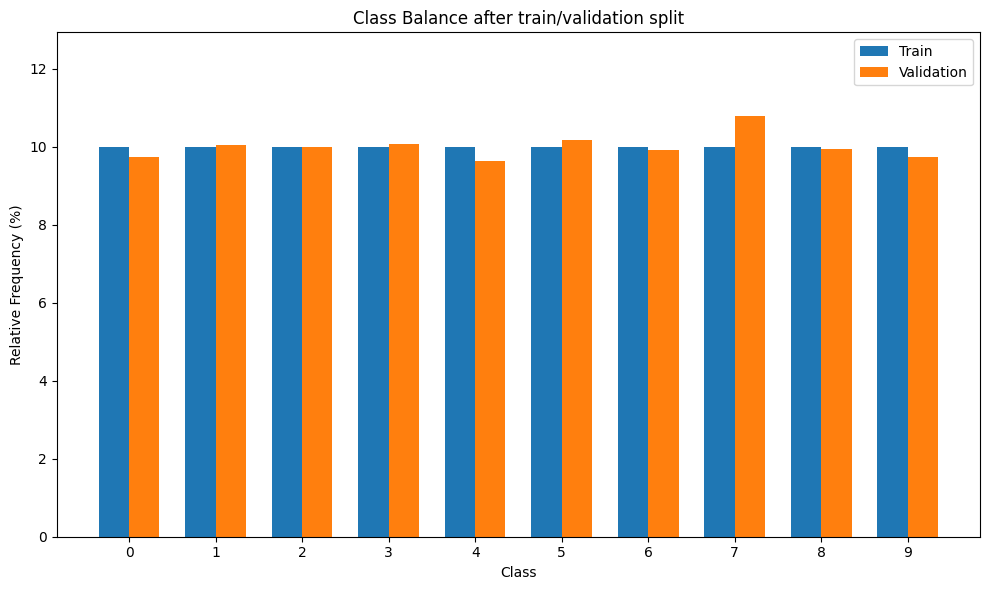

In [321]:
plot_class_balance(np.argmax(train_labels, axis=1), np.argmax(validation_labels, axis=1))

## 2.2. Save the data on the directory
(only need to do this once)

In [279]:
import os
# Save the data as .npz to prevent future download time

# create the correct folder
os.makedirs('data/train', exist_ok= True)
os.makedirs('data/validation', exist_ok= True)
os.makedirs('data/test', exist_ok= True)

# save the data separately between train and test
np.save('data/train/train_images.npy', train_images)
np.save('data/train/train_labels.npy', train_labels)
np.save('data/validation/validation_images.npy', validation_images)
np.save('data/validation/validation_labels.npy', validation_labels)
np.save('data/test/test_images.npy', test_images_source)
np.save('data/test/test_labels.npy', test_labels_source)

## 2.3 Load the data from the current directory
Use this to save time when returning to the project after leaving

In [3]:
# Load data

train_images = np.load('data/train/train_images.npy')
train_labels = np.load('data/train/train_labels.npy')
validation_images = np.load('data/validation/validation_images.npy')
validation_labels = np.load('data/validation/validation_labels.npy')
test_images = np.load('data/test/test_images.npy')
test_labels = np.load('data/test/test_labels.npy')

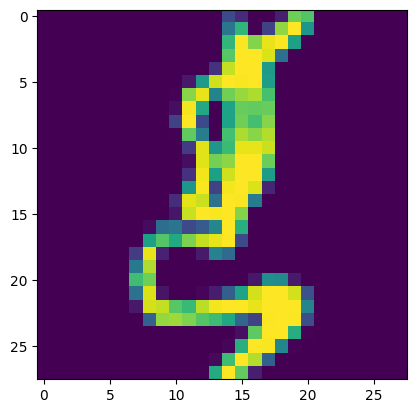

In [3]:
# Checking some of the instances in the training set

plt.imshow(train_images[11], interpolation = 'nearest')
plt.show()

## 2.4 Preprocessing
Data processing before model implementation

In [4]:
# Converting the train and validation labels to a numpy array with 10 lines (10 classes) to train the 10 output PE form the MLP

train_labels = pd.get_dummies(train_labels, dtype= int).to_numpy()
validation_labels = pd.get_dummies(validation_labels, dtype= int).to_numpy()

# Standardize the training, validation and test data

def numpy_normalize(X):
    X_norm = X / 255

    return X_norm

train_images_norm = np.array([numpy_normalize(image) for image in train_images])
validation_images_norm = np.array([numpy_normalize(image) for image in validation_images])
test_images_norm = np.array([numpy_normalize(image) for image in test_images])

# 3. Model definition
Section to define the models to use as python objects
## 3.1 MLP with 1 single hidden layer

In [112]:
# Class: MLP_1H (MLP with 1 hidden layer)
class MLP_1H:

  # Method: __init__
  def __init__(self, input_size, hidden_size, output_size, learning_rate):
      self.input_size = input_size
      self.hidden_size = hidden_size
      self.output_size = output_size

      self.sigma = 0.1
      self.miu = 0

      # Let's initialise the weights (and biases) between the inputs and the hidden layer
      self.weights_input_hidden = self.sigma * np.random.randn(self.input_size, self.hidden_size) + self.miu
      self.bias_hidden = np.zeros((1, self.hidden_size))

      # Let's initiliase the weights (and biases) between the hidden layer and the output layer
      self.weights_hidden_output = self.sigma * np.random.randn(self.hidden_size, self.output_size) + self.miu
      self.bias_output = np.zeros((1, self.output_size))

      self.learning_rate = learning_rate
      self.losses = list()
      self.val_losses = list()

      return


  # Method: Sigmoid
  def sigmoid(self, x):
      return 1 / (1 + np.exp(-x))


  # Method: Sigmoid derivative
  def sigmoid_derivative(self, x):
      return x * (1 - x)


  # Method: Forward pass
  def forward_pass(self, X):

    # Hidden layer output
    self.hidden_activation = np.dot(X, self.weights_input_hidden) + self.bias_hidden
    self.hidden_output = self.sigmoid(self.hidden_activation)

    # Output layer output
    self.output_activation = np.dot(self.hidden_output, self.weights_hidden_output) + self.bias_output
    self.predicted_output = self.sigmoid(self.output_activation)

    return self.predicted_output


  # Method: Backpropagation Algorithm
  def backpropagation_algorithm(self, X, y):

    # Step 1: Forward propagation
    y_pred = self.forward_pass(X)

    # Step 2: Compute the error
    err = y - y_pred
    # print(err)

    # Step 3: Backpropagate the errors (i.e., compute the deltas and the errors of the output(s) and hidden layer(s))
    # You will need to compute the derivative of the activation function of the neuron units (the activation function is a sigmoid)
    # Output delta (depends on the output error, err)
    output_delta = err * self.sigmoid_derivative(y_pred)
    # print(output_delta)

    # Then, we compute the errors related to the hidden layer, using the output delta (i.e., we know the magnitude of the error)
    hidden_error = np.dot(output_delta, self.weights_hidden_output.T)

    # We have to comput the delta to backpropagate to the weights of the input layer
    hidden_delta = hidden_error * self.sigmoid_derivative(self.hidden_output)

    # Step 4: Update the current weights using the notation weights_updated = weights - (derror_dweights * learning_rate)
    # As soon as you have all the errors and deltas, you can updated the weights and biases of your model
    # In this implementation, they use the delta rule
    # (+info: https://towardsdatascience.com/a-visual-explanation-of-gradient-descent-methods-momentum-adagrad-rmsprop-adam-f898b102325c/)

    # Update weights and biases of the weights between the hidden layer and the ouput
    self.weights_hidden_output += np.dot(self.hidden_output.T, output_delta) * self.learning_rate
    self.bias_output += np.sum(output_delta, axis=0, keepdims=True) * self.learning_rate

    # Update weights and biases of the weights between the input layer and the hidden layer
    self.weights_input_hidden += np.dot(X.T, hidden_delta) * self.learning_rate
    self.bias_hidden += np.sum(hidden_delta, axis=0, keepdims=True) * self.learning_rate

    return


  # Method: Train the MLP
  def train(self, X, y, epochs, X_val = None, y_val = None):
    self.epochs = epochs
    for epoch in range(epochs):
        output = self.forward_pass(X)
        self.backpropagation_algorithm(X, y)
        loss = np.mean(np.square(y - output))
        self.losses.append(loss)

        output_val = self.forward_pass(X_val)
        val_loss = np.mean(np.square(y_val - output_val))
        self.val_losses.append(val_loss)
        # print(f"Epoch {epoch}, Loss:{loss}")

### 3.1.1 MLP with 1 hidden layer created with tensorflow

In [5]:
def build_tf_model_1H(hidden_units, dropout, optimizer_name, lr):
    tf_MLP_1H = tf.keras.models.Sequential([
        tf.keras.Input(shape=(28, 28)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(hidden_units, activation= 'relu'),
        tf.keras.layers.Dropout(dropout),
        tf.keras.layers.Dense(10, activation= 'softmax')
    ])

    loss_fn = tf.losses.categorical_crossentropy

    if optimizer_name == 'sgd':
        optimizer_algorithm = tf.optimizers.SGD(learning_rate=lr)
    elif optimizer_name == 'adam':
        optimizer_algorithm = tf.optimizers.Adam(learning_rate=lr)
    else:
        raise ValueError("Unsupported optimizer")

    tf_MLP_1H.compile(optimizer = optimizer_algorithm,
                    loss = loss_fn,
                    metrics = ['accuracy',
                               tf.metrics.Precision(name='precision'),
                               tf.metrics.Recall(name='recall')])
    
    return tf_MLP_1H

## 3.2 MLP with 2 hidden layers

In [30]:
# Class: MLP_2H (MLP with 2 hidden layer)
class MLP_2H:

  # Method: __init__
  def __init__(self, input_size, hidden_size, hidden2_size, output_size, learning_rate):
      self.input_size = input_size
      self.hidden_size = hidden_size
      self.hidden2_size = hidden2_size
      self.output_size = output_size

      self.sigma = 0.1
      self.miu = 0
      # Let's initialise the weights (and biases) between the inputs and the first hidden layer
      self.weights_input_hidden = self.sigma * np.random.randn(self.input_size, self.hidden_size) + self.miu
      self.bias_hidden = np.zeros((1, self.hidden_size))

      # Let's initiliase the weights (and biases) between the first and second hidden layer
      self.weights_hidden_output = self.sigma * np.random.randn(self.hidden_size, self.hidden2_size) + self.miu
      self.bias_hidden2 = np.zeros((1, self.hidden2_size))

      # Let's initiliase the weights (and biases) between the second hidden layer and the output layer
      self.weights_hidden2_output = self.sigma * np.random.randn(self.hidden2_size, self.output_size) + self.miu
      self.bias_output = np.zeros((1, self.output_size))

      self.learning_rate = learning_rate
      self.losses = list()
      self.val_losses = list()

      return


  # Method: Sigmoid
  def sigmoid(self, x):
      return 1 / (1 + np.exp(-x))


  # Method: Sigmoid derivative
  def sigmoid_derivative(self, x):
      return x * (1 - x)


  # Method: Forward pass
  def forward_pass(self, X):

    # Hidden layer output
    self.hidden_activation = np.dot(X, self.weights_input_hidden) + self.bias_hidden
    self.hidden_output = self.sigmoid(self.hidden_activation)

    # Second Hidden layer output
    self.hidden2_activation = np.dot(self.hidden_output, self.weights_hidden_output) + self.bias_hidden2
    self.hidden2_output = self.sigmoid(self.hidden2_activation)

    # Output layer output
    self.output_activation = np.dot(self.hidden2_output, self.weights_hidden2_output) + self.bias_output
    self.predicted_output = self.sigmoid(self.output_activation)

    return self.predicted_output


  # Method: Backpropagation Algorithm
  def backpropagation_algorithm(self, X, y):

    # Step 1: Forward propagation
    y_pred = self.forward_pass(X)

    # Step 2: Compute the error
    err = y - y_pred

    # Step 3: Backpropagate the errors (i.e., compute the deltas and the errors of the output(s) and hidden layer(s))
    # You will need to compute the derivative of the activation function of the neuron units (the activation function is a sigmoid)
    # Output delta (depends on the output error, err)
    output_delta = err * self.sigmoid_derivative(y_pred)
    # print(output_delta)

    # Then, we compute the errors related to the hidden layer, using the output delta (i.e., we know the magnitude of the error)
    hidden2_error = np.dot(output_delta, self.weights_hidden2_output.T)

    # We have to comput the delta to backpropagate to the weights of the input layer
    hidden2_delta = hidden2_error * self.sigmoid_derivative(self.hidden2_output)

    # Then, we compute the errors related to the hidden layer, using the output delta (i.e., we know the magnitude of the error)
    hidden_error = np.dot(hidden2_delta, self.weights_hidden_output.T)

    # We have to comput the delta to backpropagate to the weights of the input layer
    hidden_delta = hidden_error * self.sigmoid_derivative(self.hidden_output)

    # Step 4: Update the current weights using the notation weights_updated = weights - (derror_dweights * learning_rate)
    # As soon as you have all the errors and deltas, you can updated the weights and biases of your model
    # In this implementation, they use the delta rule
    # (+info: https://towardsdatascience.com/a-visual-explanation-of-gradient-descent-methods-momentum-adagrad-rmsprop-adam-f898b102325c/)

    # Update weights and biases of the weights between the second hidden layer and the ouput
    
    self.weights_hidden2_output += np.dot(self.hidden2_output.T, output_delta) * self.learning_rate
    self.bias_output += np.sum(output_delta, axis=0, keepdims=True) * self.learning_rate

    # Update weights and biases of the weights between the two hidden layers
    
    self.weights_hidden_output += np.dot(self.hidden_output.T, hidden2_delta) * self.learning_rate
    self.bias_hidden2 += np.sum(hidden2_delta, axis=0, keepdims=True) * self.learning_rate

    # Update weights and biases of the weights between the input layer and the hidden layer
    self.weights_input_hidden += np.dot(X.T, hidden_delta) * self.learning_rate
    self.bias_hidden += np.sum(hidden_delta, axis=0, keepdims=True) * self.learning_rate

    return


  # Method: Train the MLP
  def train(self, X, y, epochs, X_val = None, y_val = None):
    self.epochs = epochs
    for epoch in range(epochs):
        output = self.forward_pass(X)
        self.backpropagation_algorithm(X, y)
        loss = np.mean(np.square(y - output))
        self.losses.append(loss)

        output_val = self.forward_pass(X_val)
        val_loss = np.mean(np.square(y_val - output_val))
        self.val_losses.append(val_loss)
        # print(f"Epoch {epoch}, Loss:{loss}")
        

    return

## 3.3 MLP with 3 hidden layers

In [9]:
def build_tf_model_3H(hidden_units1, hidden_units2, hidden_units3, dropout, optimizer_name, lr):
    tf_MLP_3H = tf.keras.models.Sequential([
        tf.keras.Input(shape=(28, 28)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(hidden_units1, activation= 'relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout),
        tf.keras.layers.Dense(hidden_units2, activation= 'relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout),
        tf.keras.layers.Dense(hidden_units3, activation= 'relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout),
        tf.keras.layers.Dense(10, activation= 'softmax')
    ])

    loss_fn = tf.losses.categorical_crossentropy

    if optimizer_name == 'sgd':
        optimizer_algorithm = tf.optimizers.SGD(learning_rate=lr)
    elif optimizer_name == 'adam':
        optimizer_algorithm = tf.optimizers.Adam(learning_rate=lr)
    else:
        raise ValueError("Unsupported optimizer")

    tf_MLP_3H.compile(optimizer = optimizer_algorithm,
                    loss = loss_fn,
                    metrics = ['accuracy',
                               tf.metrics.Precision(name='precision'),
                               tf.metrics.Recall(name='recall')])
    
    return tf_MLP_3H

# 4. Running the models

In [30]:
# Ploting accuracy and loss for both the training and validation sets

def plot_training_results(model_history):
    plt.figure(figsize=(12, 5))

    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(model_history.history['accuracy'], label='Train Accuracy', color='blue')
    if 'val_accuracy' in model_history.history:
        plt.plot(model_history.history['val_accuracy'], label='Val Accuracy', color='red')
    plt.title('Accuracy over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(False)

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(model_history.history['loss'], label='Train Loss', color='blue')
    if 'val_loss' in model_history.history:
        plt.plot(model_history.history['val_loss'], label='Val Loss', color='red')
    plt.title('Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(False)

    plt.tight_layout()
    plt.show()

# Ploting accuracy and loss for both the training and validation sets

def plot_finalTraining_results(model_history):
    plt.figure(figsize=(12, 5))

    # Plot accuracy
    plt.subplot(2, 1, 2)
    plt.plot(model_history.history['accuracy'], label='Train Accuracy', color='#9be034')
    if 'val_accuracy' in model_history.history:
        plt.plot(model_history.history['val_accuracy'], label='Test Accuracy', color='red')
    plt.title('Accuracy')
    #plt.xlabel('Epoch')
    #plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(False)

    # Plot loss
    plt.subplot(2, 1, 1)
    plt.plot(model_history.history['loss'], label='Train Loss', color='#9be034')
    if 'val_loss' in model_history.history:
        plt.plot(model_history.history['val_loss'], label='Test Loss', color='red')
    plt.title('Loss')
    #plt.xlabel('Epoch')
    #plt.ylabel('Loss')
    plt.legend()
    plt.grid(False)

    plt.tight_layout()
    plt.show()

## 4.1 MLP with 1 hidden layer

Epoch 1/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.3248 - loss: 2.0197 - val_accuracy: 0.6833 - val_loss: 1.2696
Epoch 2/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 1s 843us/step - accuracy: 0.6795 - loss: 1.1959 - val_accuracy: 0.7463 - val_loss: 0.9460
Epoch 3/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 1s 890us/step - accuracy: 0.7312 - loss: 0.9443 - val_accuracy: 0.7825 - val_loss: 0.8029
Epoch 4/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 1s 859us/step - accuracy: 0.7715 - loss: 0.8074 - val_accuracy: 0.8046 - val_loss: 0.7192
Epoch 5/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 1s 868us/step - accuracy: 0.7898 - loss: 0.7330 - val_accuracy: 0.8180 - val_loss: 0.6631
Epoch 6/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 1s 908us/step - accuracy: 0.8040 - loss: 0.6833 - val_accuracy: 0.8273 - val_loss: 0.6221
Epoch 7/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 1s 852us/step - accuracy: 0.8177 - loss: 0.6320 - val_accuracy: 0.8347 - val_loss: 0.5906
Epoch 8/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 1s 906us/step - accuracy: 0.

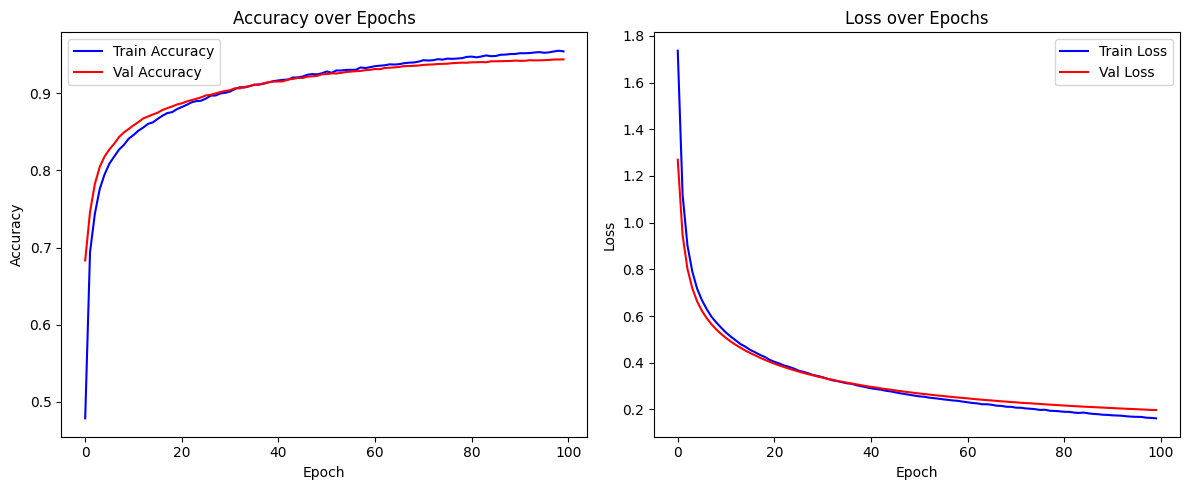

In [259]:
history = tf_MLP_1H.fit(train_images_norm, train_labels, epochs= 100, validation_split=0.2)

# Plot losses and accuracy
plot_training_results(history)

### 4.1.1 Conduct a grid search to fine tune some hyperparameters
Test multiple combinations of learning rate, dropout, hidden units and optimizers

In [7]:
learning_rates = [1e-2, 1e-3, 1e-4, 1e-5]
dropouts = [0.0, 0.2, 0.5]
hidden_neurons = [12, 64, 128, 256]
optimizers_list = ['sgd', 'adam']

# Grid search
results = []

# Ensure the file to save the models exists
os.makedirs("mlp1H_saved_models_run2", exist_ok=True)

# Create the full grid of hyperparameters
grid = list(itertools.product(learning_rates, dropouts, hidden_neurons, optimizers_list))

start_time = time.time()

for lr, dr, hu, opt_name in tqdm(grid, desc="Grid Search Progress"):
    config_name = f"lr{lr}_do{dr}_hu{hu}_{opt_name}"
    model_path = f"mlp1H_saved_models_run2/model_{config_name}.keras"

    print(f"Testing: {config_name}")

    model = build_tf_model_1H(hidden_units=hu, dropout=dr, optimizer_name=opt_name, lr=lr)

    # Save best model on validation accuracy
    checkpoint = ModelCheckpoint(
        filepath=model_path,
        monitor='val_accuracy',
        save_best_only=True,
        save_weights_only=False,
        mode='max',
        verbose=0
    )

    early_stop = EarlyStopping(
        monitor='loss',
        min_delta = 0.01,    
        patience=5,            # number of epochs with no improvement after which training will be stopped
        restore_best_weights=True,
        mode = 'min',
        verbose = 1  # restores model weights from the epoch with the best value of the monitored quantity
    )

    history = model.fit(train_images_norm, train_labels, epochs=100, validation_data=(validation_images_norm, validation_labels), callbacks = [checkpoint, early_stop], verbose=0)
    
    # Evaluate the saved best model
    try:
        best_model = tf.keras.models.load_model(model_path)
        val_loss, val_acc, val_precision, val_recall = best_model.evaluate(validation_images_norm, validation_labels, verbose=0)

        results.append({
            'learning_rate': lr,
            'dropout': dr,
            'hidden_neurons': hu,
            'optimizer': opt_name,
            'val_accuracy': val_acc,
            'val_precision': val_precision,
            'val_recall': val_recall,
            'model_path': model_path
        })
    except Exception as e:
        print(f"Failed to evaluate model {config_name}: {e}")   

print(f"Total grid search time: {(time.time() - start_time)/60:.2f} minutes")

# Save the results of the grid search
with open("mlp1H_grid_search_results_run2.json", "w") as f:
    json.dump(results, f, indent=4)

# Sort results by best validation accuracy
results = sorted(results, key=lambda x: x['val_accuracy'], reverse=True)

# Print top 5 configs
for r in results[:5]:
    print(r)

Grid Search Progress:   0%|          | 0/96 [00:00<?, ?it/s]

Testing: lr0.01_do0.0_hu12_sgd
Epoch 31: early stopping
Restoring model weights from the end of the best epoch: 26.


Grid Search Progress:   1%|          | 1/96 [00:42<1:07:16, 42.49s/it]

Testing: lr0.01_do0.0_hu12_adam
Epoch 17: early stopping
Restoring model weights from the end of the best epoch: 12.


Grid Search Progress:   2%|▏         | 2/96 [01:09<52:36, 33.58s/it]  

Testing: lr0.01_do0.0_hu64_sgd
Epoch 55: early stopping
Restoring model weights from the end of the best epoch: 50.


Grid Search Progress:   3%|▎         | 3/96 [02:34<1:28:08, 56.86s/it]

Testing: lr0.01_do0.0_hu64_adam
Epoch 30: early stopping
Restoring model weights from the end of the best epoch: 25.


Grid Search Progress:   4%|▍         | 4/96 [03:24<1:23:10, 54.24s/it]

Testing: lr0.01_do0.0_hu128_sgd
Epoch 51: early stopping
Restoring model weights from the end of the best epoch: 46.


Grid Search Progress:   5%|▌         | 5/96 [04:49<1:39:15, 65.44s/it]

Testing: lr0.01_do0.0_hu128_adam
Epoch 25: early stopping
Restoring model weights from the end of the best epoch: 20.


Grid Search Progress:   6%|▋         | 6/96 [05:47<1:33:57, 62.64s/it]

Testing: lr0.01_do0.0_hu256_sgd
Epoch 47: early stopping
Restoring model weights from the end of the best epoch: 42.


Grid Search Progress:   7%|▋         | 7/96 [07:25<1:50:00, 74.17s/it]

Testing: lr0.01_do0.0_hu256_adam
Epoch 25: early stopping
Restoring model weights from the end of the best epoch: 20.


Grid Search Progress:   8%|▊         | 8/96 [08:32<1:45:45, 72.11s/it]

Testing: lr0.01_do0.2_hu12_sgd
Epoch 29: early stopping
Restoring model weights from the end of the best epoch: 24.


Grid Search Progress:   9%|▉         | 9/96 [09:17<1:32:23, 63.72s/it]

Testing: lr0.01_do0.2_hu12_adam
Epoch 9: early stopping
Restoring model weights from the end of the best epoch: 4.


Grid Search Progress:  10%|█         | 10/96 [09:32<1:09:46, 48.68s/it]

Testing: lr0.01_do0.2_hu64_sgd
Epoch 38: early stopping
Restoring model weights from the end of the best epoch: 33.


Grid Search Progress:  11%|█▏        | 11/96 [10:33<1:14:09, 52.35s/it]

Testing: lr0.01_do0.2_hu64_adam
Epoch 23: early stopping
Restoring model weights from the end of the best epoch: 18.


Grid Search Progress:  12%|█▎        | 12/96 [11:14<1:08:20, 48.81s/it]

Testing: lr0.01_do0.2_hu128_sgd
Epoch 46: early stopping
Restoring model weights from the end of the best epoch: 41.


Grid Search Progress:  14%|█▎        | 13/96 [12:32<1:19:36, 57.55s/it]

Testing: lr0.01_do0.2_hu128_adam
Epoch 21: early stopping
Restoring model weights from the end of the best epoch: 16.


Grid Search Progress:  15%|█▍        | 14/96 [13:19<1:14:17, 54.36s/it]

Testing: lr0.01_do0.2_hu256_sgd
Epoch 52: early stopping
Restoring model weights from the end of the best epoch: 47.


Grid Search Progress:  16%|█▌        | 15/96 [15:09<1:36:23, 71.40s/it]

Testing: lr0.01_do0.2_hu256_adam
Epoch 21: early stopping
Restoring model weights from the end of the best epoch: 16.


Grid Search Progress:  17%|█▋        | 16/96 [16:05<1:29:02, 66.79s/it]

Testing: lr0.01_do0.5_hu12_sgd
Epoch 25: early stopping
Restoring model weights from the end of the best epoch: 20.


Grid Search Progress:  18%|█▊        | 17/96 [16:42<1:15:53, 57.64s/it]

Testing: lr0.01_do0.5_hu12_adam
Epoch 23: early stopping
Restoring model weights from the end of the best epoch: 18.


Grid Search Progress:  19%|█▉        | 18/96 [17:16<1:05:45, 50.59s/it]

Testing: lr0.01_do0.5_hu64_sgd
Epoch 37: early stopping
Restoring model weights from the end of the best epoch: 32.


Grid Search Progress:  20%|█▉        | 19/96 [18:11<1:06:45, 52.01s/it]

Testing: lr0.01_do0.5_hu64_adam
Epoch 15: early stopping
Restoring model weights from the end of the best epoch: 10.


Grid Search Progress:  21%|██        | 20/96 [18:37<55:55, 44.14s/it]  

Testing: lr0.01_do0.5_hu128_sgd
Epoch 44: early stopping
Restoring model weights from the end of the best epoch: 39.


Grid Search Progress:  22%|██▏       | 21/96 [19:52<1:06:33, 53.24s/it]

Testing: lr0.01_do0.5_hu128_adam
Epoch 22: early stopping
Restoring model weights from the end of the best epoch: 17.


Grid Search Progress:  23%|██▎       | 22/96 [20:41<1:04:23, 52.21s/it]

Testing: lr0.01_do0.5_hu256_sgd
Epoch 43: early stopping
Restoring model weights from the end of the best epoch: 38.


Grid Search Progress:  24%|██▍       | 23/96 [22:12<1:17:31, 63.72s/it]

Testing: lr0.01_do0.5_hu256_adam
Epoch 23: early stopping
Restoring model weights from the end of the best epoch: 18.


Grid Search Progress:  25%|██▌       | 24/96 [23:12<1:15:07, 62.61s/it]

Testing: lr0.001_do0.0_hu12_sgd
Epoch 56: early stopping
Restoring model weights from the end of the best epoch: 51.


Grid Search Progress:  26%|██▌       | 25/96 [24:31<1:19:58, 67.58s/it]

Testing: lr0.001_do0.0_hu12_adam
Epoch 26: early stopping
Restoring model weights from the end of the best epoch: 21.


Grid Search Progress:  27%|██▋       | 26/96 [25:09<1:08:34, 58.78s/it]

Testing: lr0.001_do0.0_hu64_sgd
Epoch 76: early stopping
Restoring model weights from the end of the best epoch: 71.


Grid Search Progress:  28%|██▊       | 27/96 [27:04<1:26:46, 75.45s/it]

Testing: lr0.001_do0.0_hu64_adam
Epoch 28: early stopping
Restoring model weights from the end of the best epoch: 23.


Grid Search Progress:  29%|██▉       | 28/96 [27:52<1:16:18, 67.33s/it]

Testing: lr0.001_do0.0_hu128_sgd
Epoch 81: early stopping
Restoring model weights from the end of the best epoch: 76.


Grid Search Progress:  30%|███       | 29/96 [30:07<1:37:41, 87.48s/it]

Testing: lr0.001_do0.0_hu128_adam
Epoch 20: early stopping
Restoring model weights from the end of the best epoch: 15.


Grid Search Progress:  31%|███▏      | 30/96 [30:52<1:22:26, 74.94s/it]

Testing: lr0.001_do0.0_hu256_sgd
Epoch 82: early stopping
Restoring model weights from the end of the best epoch: 77.


Grid Search Progress:  32%|███▏      | 31/96 [33:39<1:50:54, 102.37s/it]

Testing: lr0.001_do0.0_hu256_adam
Epoch 15: early stopping
Restoring model weights from the end of the best epoch: 10.


Grid Search Progress:  33%|███▎      | 32/96 [34:18<1:28:57, 83.40s/it] 

Testing: lr0.001_do0.2_hu12_sgd
Epoch 45: early stopping
Restoring model weights from the end of the best epoch: 40.


Grid Search Progress:  34%|███▍      | 33/96 [35:22<1:21:26, 77.56s/it]

Testing: lr0.001_do0.2_hu12_adam
Epoch 21: early stopping
Restoring model weights from the end of the best epoch: 16.


Grid Search Progress:  35%|███▌      | 34/96 [35:53<1:05:42, 63.59s/it]

Testing: lr0.001_do0.2_hu64_sgd
Epoch 70: early stopping
Restoring model weights from the end of the best epoch: 65.


Grid Search Progress:  36%|███▋      | 35/96 [37:38<1:17:15, 75.99s/it]

Testing: lr0.001_do0.2_hu64_adam
Epoch 29: early stopping
Restoring model weights from the end of the best epoch: 24.


Grid Search Progress:  38%|███▊      | 36/96 [38:29<1:08:39, 68.66s/it]

Testing: lr0.001_do0.2_hu128_sgd
Epoch 72: early stopping
Restoring model weights from the end of the best epoch: 67.


Grid Search Progress:  39%|███▊      | 37/96 [40:31<1:23:14, 84.65s/it]

Testing: lr0.001_do0.2_hu128_adam
Epoch 23: early stopping
Restoring model weights from the end of the best epoch: 18.


Grid Search Progress:  40%|███▉      | 38/96 [41:23<1:12:26, 74.94s/it]

Testing: lr0.001_do0.2_hu256_sgd
Epoch 69: early stopping
Restoring model weights from the end of the best epoch: 64.


Grid Search Progress:  41%|████      | 39/96 [43:50<1:31:27, 96.27s/it]

Testing: lr0.001_do0.2_hu256_adam
Epoch 24: early stopping
Restoring model weights from the end of the best epoch: 19.


Grid Search Progress:  42%|████▏     | 40/96 [44:53<1:20:35, 86.35s/it]

Testing: lr0.001_do0.5_hu12_sgd
Epoch 41: early stopping
Restoring model weights from the end of the best epoch: 36.


Grid Search Progress:  43%|████▎     | 41/96 [45:51<1:11:31, 78.03s/it]

Testing: lr0.001_do0.5_hu12_adam
Epoch 20: early stopping
Restoring model weights from the end of the best epoch: 15.


Grid Search Progress:  44%|████▍     | 42/96 [46:21<57:12, 63.57s/it]  

Testing: lr0.001_do0.5_hu64_sgd
Epoch 66: early stopping
Restoring model weights from the end of the best epoch: 61.


Grid Search Progress:  45%|████▍     | 43/96 [48:00<1:05:26, 74.08s/it]

Testing: lr0.001_do0.5_hu64_adam
Epoch 22: early stopping
Restoring model weights from the end of the best epoch: 17.


Grid Search Progress:  46%|████▌     | 44/96 [48:39<55:08, 63.63s/it]  

Testing: lr0.001_do0.5_hu128_sgd
Epoch 63: early stopping
Restoring model weights from the end of the best epoch: 58.


Grid Search Progress:  47%|████▋     | 45/96 [50:25<1:04:51, 76.30s/it]

Testing: lr0.001_do0.5_hu128_adam
Epoch 40: early stopping
Restoring model weights from the end of the best epoch: 35.


Grid Search Progress:  48%|████▊     | 46/96 [51:54<1:06:49, 80.19s/it]

Testing: lr0.001_do0.5_hu256_sgd
Epoch 72: early stopping
Restoring model weights from the end of the best epoch: 67.


Grid Search Progress:  49%|████▉     | 47/96 [54:25<1:22:44, 101.31s/it]

Testing: lr0.001_do0.5_hu256_adam
Epoch 31: early stopping
Restoring model weights from the end of the best epoch: 26.


Grid Search Progress:  50%|█████     | 48/96 [55:45<1:16:04, 95.10s/it] 

Testing: lr0.0001_do0.0_hu12_sgd
Restoring model weights from the end of the best epoch: 98.


Grid Search Progress:  51%|█████     | 49/96 [58:07<1:25:29, 109.14s/it]

Testing: lr0.0001_do0.0_hu12_adam
Epoch 38: early stopping
Restoring model weights from the end of the best epoch: 33.


Grid Search Progress:  52%|█████▏    | 50/96 [59:03<1:11:26, 93.18s/it] 

Testing: lr0.0001_do0.0_hu64_sgd
Restoring model weights from the end of the best epoch: 97.


Grid Search Progress:  53%|█████▎    | 51/96 [1:01:33<1:22:43, 110.30s/it]

Testing: lr0.0001_do0.0_hu64_adam
Epoch 58: early stopping
Restoring model weights from the end of the best epoch: 53.


Grid Search Progress:  54%|█████▍    | 52/96 [1:03:09<1:17:44, 106.02s/it]

Testing: lr0.0001_do0.0_hu128_sgd
Restoring model weights from the end of the best epoch: 96.


Grid Search Progress:  55%|█████▌    | 53/96 [1:05:55<1:28:47, 123.90s/it]

Testing: lr0.0001_do0.0_hu128_adam
Epoch 46: early stopping
Restoring model weights from the end of the best epoch: 41.


Grid Search Progress:  56%|█████▋    | 54/96 [1:07:37<1:22:04, 117.26s/it]

Testing: lr0.0001_do0.0_hu256_sgd
Epoch 99: early stopping
Restoring model weights from the end of the best epoch: 94.


Grid Search Progress:  57%|█████▋    | 55/96 [1:11:01<1:38:01, 143.46s/it]

Testing: lr0.0001_do0.0_hu256_adam
Epoch 39: early stopping
Restoring model weights from the end of the best epoch: 34.


Grid Search Progress:  58%|█████▊    | 56/96 [1:12:42<1:27:01, 130.53s/it]

Testing: lr0.0001_do0.2_hu12_sgd
Restoring model weights from the end of the best epoch: 98.


Grid Search Progress:  59%|█████▉    | 57/96 [1:15:04<1:27:01, 133.88s/it]

Testing: lr0.0001_do0.2_hu12_adam
Epoch 30: early stopping
Restoring model weights from the end of the best epoch: 25.


Grid Search Progress:  60%|██████    | 58/96 [1:15:48<1:07:47, 107.04s/it]

Testing: lr0.0001_do0.2_hu64_sgd
Restoring model weights from the end of the best epoch: 99.


Grid Search Progress:  61%|██████▏   | 59/96 [1:18:18<1:13:54, 119.85s/it]

Testing: lr0.0001_do0.2_hu64_adam
Epoch 44: early stopping
Restoring model weights from the end of the best epoch: 39.


Grid Search Progress:  62%|██████▎   | 60/96 [1:19:32<1:03:45, 106.27s/it]

Testing: lr0.0001_do0.2_hu128_sgd
Restoring model weights from the end of the best epoch: 97.


Grid Search Progress:  64%|██████▎   | 61/96 [1:22:19<1:12:29, 124.27s/it]

Testing: lr0.0001_do0.2_hu128_adam
Epoch 50: early stopping
Restoring model weights from the end of the best epoch: 45.


Grid Search Progress:  65%|██████▍   | 62/96 [1:24:11<1:08:26, 120.78s/it]

Testing: lr0.0001_do0.2_hu256_sgd
Epoch 95: early stopping
Restoring model weights from the end of the best epoch: 90.


Grid Search Progress:  66%|██████▌   | 63/96 [1:27:34<1:20:00, 145.46s/it]

Testing: lr0.0001_do0.2_hu256_adam
Epoch 37: early stopping
Restoring model weights from the end of the best epoch: 32.


Grid Search Progress:  67%|██████▋   | 64/96 [1:29:12<1:09:58, 131.20s/it]

Testing: lr0.0001_do0.5_hu12_sgd
Epoch 92: early stopping
Restoring model weights from the end of the best epoch: 87.


Grid Search Progress:  68%|██████▊   | 65/96 [1:31:25<1:08:02, 131.70s/it]

Testing: lr0.0001_do0.5_hu12_adam
Epoch 27: early stopping
Restoring model weights from the end of the best epoch: 22.


Grid Search Progress:  69%|██████▉   | 66/96 [1:32:06<52:12, 104.43s/it]  

Testing: lr0.0001_do0.5_hu64_sgd
Restoring model weights from the end of the best epoch: 98.


Grid Search Progress:  70%|██████▉   | 67/96 [1:34:37<57:12, 118.37s/it]

Testing: lr0.0001_do0.5_hu64_adam
Epoch 37: early stopping
Restoring model weights from the end of the best epoch: 32.


Grid Search Progress:  71%|███████   | 68/96 [1:35:40<47:30, 101.80s/it]

Testing: lr0.0001_do0.5_hu128_sgd
Restoring model weights from the end of the best epoch: 97.


Grid Search Progress:  72%|███████▏  | 69/96 [1:38:25<54:20, 120.77s/it]

Testing: lr0.0001_do0.5_hu128_adam
Epoch 43: early stopping
Restoring model weights from the end of the best epoch: 38.


Grid Search Progress:  73%|███████▎  | 70/96 [1:40:01<49:07, 113.36s/it]

Testing: lr0.0001_do0.5_hu256_sgd
Restoring model weights from the end of the best epoch: 98.


Grid Search Progress:  74%|███████▍  | 71/96 [1:43:27<58:52, 141.31s/it]

Testing: lr0.0001_do0.5_hu256_adam
Epoch 50: early stopping
Restoring model weights from the end of the best epoch: 45.


Grid Search Progress:  75%|███████▌  | 72/96 [1:45:36<54:57, 137.39s/it]

Testing: lr1e-05_do0.0_hu12_sgd
Restoring model weights from the end of the best epoch: 98.


Grid Search Progress:  76%|███████▌  | 73/96 [1:47:59<53:19, 139.13s/it]

Testing: lr1e-05_do0.0_hu12_adam
Epoch 69: early stopping
Restoring model weights from the end of the best epoch: 64.


Grid Search Progress:  77%|███████▋  | 74/96 [1:49:43<47:07, 128.50s/it]

Testing: lr1e-05_do0.0_hu64_sgd
Restoring model weights from the end of the best epoch: 100.


Grid Search Progress:  78%|███████▊  | 75/96 [1:52:15<47:30, 135.73s/it]

Testing: lr1e-05_do0.0_hu64_adam
Epoch 79: early stopping
Restoring model weights from the end of the best epoch: 74.


Grid Search Progress:  79%|███████▉  | 76/96 [1:54:30<45:10, 135.50s/it]

Testing: lr1e-05_do0.0_hu128_sgd
Restoring model weights from the end of the best epoch: 99.


Grid Search Progress:  80%|████████  | 77/96 [1:57:20<46:08, 145.71s/it]

Testing: lr1e-05_do0.0_hu128_adam
Epoch 76: early stopping
Restoring model weights from the end of the best epoch: 71.


Grid Search Progress:  81%|████████▏ | 78/96 [2:00:29<47:38, 158.80s/it]

Testing: lr1e-05_do0.0_hu256_sgd
Restoring model weights from the end of the best epoch: 99.


Grid Search Progress:  82%|████████▏ | 79/96 [2:04:06<49:57, 176.32s/it]

Testing: lr1e-05_do0.0_hu256_adam
Epoch 73: early stopping
Restoring model weights from the end of the best epoch: 68.


Grid Search Progress:  83%|████████▎ | 80/96 [2:07:43<50:14, 188.38s/it]

Testing: lr1e-05_do0.2_hu12_sgd
Epoch 66: early stopping
Restoring model weights from the end of the best epoch: 61.


Grid Search Progress:  84%|████████▍ | 81/96 [2:09:28<40:51, 163.45s/it]

Testing: lr1e-05_do0.2_hu12_adam
Epoch 68: early stopping
Restoring model weights from the end of the best epoch: 63.


Grid Search Progress:  85%|████████▌ | 82/96 [2:11:16<34:16, 146.92s/it]

Testing: lr1e-05_do0.2_hu64_sgd
Restoring model weights from the end of the best epoch: 99.


Grid Search Progress:  86%|████████▋ | 83/96 [2:14:01<32:59, 152.27s/it]

Testing: lr1e-05_do0.2_hu64_adam
Epoch 74: early stopping
Restoring model weights from the end of the best epoch: 69.


Grid Search Progress:  88%|████████▊ | 84/96 [2:16:21<29:42, 148.51s/it]

Testing: lr1e-05_do0.2_hu128_sgd
Restoring model weights from the end of the best epoch: 100.


Grid Search Progress:  89%|████████▊ | 85/96 [2:19:26<29:14, 159.46s/it]

Testing: lr1e-05_do0.2_hu128_adam
Epoch 83: early stopping
Restoring model weights from the end of the best epoch: 78.


Grid Search Progress:  90%|████████▉ | 86/96 [2:22:59<29:15, 175.59s/it]

Testing: lr1e-05_do0.2_hu256_sgd
Restoring model weights from the end of the best epoch: 100.


Grid Search Progress:  91%|█████████ | 87/96 [2:26:57<29:07, 194.19s/it]

Testing: lr1e-05_do0.2_hu256_adam
Epoch 71: early stopping
Restoring model weights from the end of the best epoch: 66.


Grid Search Progress:  92%|█████████▏| 88/96 [2:30:36<26:54, 201.78s/it]

Testing: lr1e-05_do0.5_hu12_sgd
Epoch 91: early stopping
Restoring model weights from the end of the best epoch: 86.


Grid Search Progress:  93%|█████████▎| 89/96 [2:32:43<20:54, 179.17s/it]

Testing: lr1e-05_do0.5_hu12_adam
Epoch 55: early stopping
Restoring model weights from the end of the best epoch: 50.


Grid Search Progress:  94%|█████████▍| 90/96 [2:33:57<14:46, 147.68s/it]

Testing: lr1e-05_do0.5_hu64_sgd
Restoring model weights from the end of the best epoch: 100.


Grid Search Progress:  95%|█████████▍| 91/96 [2:36:32<12:29, 149.85s/it]

Testing: lr1e-05_do0.5_hu64_adam
Epoch 66: early stopping
Restoring model weights from the end of the best epoch: 61.


Grid Search Progress:  96%|█████████▌| 92/96 [2:38:27<09:17, 139.34s/it]

Testing: lr1e-05_do0.5_hu128_sgd
Restoring model weights from the end of the best epoch: 100.


Grid Search Progress:  97%|█████████▋| 93/96 [2:41:17<07:26, 148.74s/it]

Testing: lr1e-05_do0.5_hu128_adam
Epoch 60: early stopping
Restoring model weights from the end of the best epoch: 55.


Grid Search Progress:  98%|█████████▊| 94/96 [2:43:20<04:42, 141.09s/it]

Testing: lr1e-05_do0.5_hu256_sgd
Restoring model weights from the end of the best epoch: 100.


Grid Search Progress:  99%|█████████▉| 95/96 [2:46:39<02:38, 158.22s/it]

Testing: lr1e-05_do0.5_hu256_adam
Epoch 68: early stopping
Restoring model weights from the end of the best epoch: 63.


Grid Search Progress: 100%|██████████| 96/96 [2:49:29<00:00, 105.94s/it]

Total grid search time: 169.50 minutes
{'learning_rate': 0.001, 'dropout': 0.2, 'hidden_neurons': 256, 'optimizer': 'adam', 'val_accuracy': 0.9623333215713501, 'val_precision': 0.9652115702629089, 'val_recall': 0.9618333578109741, 'model_path': 'mlp1H_saved_models_run2/model_lr0.001_do0.2_hu256_adam.keras'}
{'learning_rate': 0.0001, 'dropout': 0.2, 'hidden_neurons': 256, 'optimizer': 'adam', 'val_accuracy': 0.9599999785423279, 'val_precision': 0.9668410420417786, 'val_recall': 0.9549166560173035, 'model_path': 'mlp1H_saved_models_run2/model_lr0.0001_do0.2_hu256_adam.keras'}
{'learning_rate': 0.0001, 'dropout': 0.5, 'hidden_neurons': 256, 'optimizer': 'adam', 'val_accuracy': 0.9599166512489319, 'val_precision': 0.9678456783294678, 'val_recall': 0.953166663646698, 'model_path': 'mlp1H_saved_models_run2/model_lr0.0001_do0.5_hu256_adam.keras'}
{'learning_rate': 0.001, 'dropout': 0.5, 'hidden_neurons': 256, 'optimizer': 'adam', 'val_accuracy': 0.9597499966621399, 'val_precision': 0.96378874

In [8]:
end_time = time.time()
gridSearch_MLP_1H_time = end_time - start_time
print(f"Total grid search time: {(time.time() - start_time)/60:.2f} minutes")

Total grid search time: 169.51 minutes


### 4.1.2. Retrieve best run

In [12]:
# Read the grid search results and convert to a data frame
results_MLP_1H = pd.read_json('mlp1H_grid_search_results_run2.json')

# Correct the model path (altered after grid search run)
results_MLP_1H['model_path'] = results_MLP_1H['model_path'].str.replace('saved_models', 'mlp1H_saved_models', regex= False)

results_MLP_1H.head()

,learning_rate,dropout,hidden_neurons,optimizer,val_accuracy,val_precision,val_recall,model_path
0,0.01,0.0,12,sgd,0.868750,0.899377,0.841667,mlp1H_mlp1H_saved_models_run2/model_lr0.01_do0...
1,0.01,0.0,12,adam,0.855167,0.884840,0.831750,mlp1H_mlp1H_saved_models_run2/model_lr0.01_do0...
2,0.01,0.0,64,sgd,0.940000,0.950574,0.931167,mlp1H_mlp1H_saved_models_run2/model_lr0.01_do0...
3,0.01,0.0,64,adam,0.916917,0.933774,0.905917,mlp1H_mlp1H_saved_models_run2/model_lr0.01_do0...
4,0.01,0.0,128,sgd,0.948167,0.959274,0.938250,mlp1H_mlp1H_saved_models_run2/model_lr0.01_do0...


Best grid search accuracy: 0.9623333215713501
Best run index: 39
Epoch 1/300
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.8238 - loss: 0.5802 - precision: 0.9087 - recall: 0.7446 - val_accuracy: 0.8526 - val_loss: 0.4741 - val_precision: 0.8978 - val_recall: 0.8196
Epoch 2/300
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9393 - loss: 0.2036 - precision: 0.9572 - recall: 0.9242 - val_accuracy: 0.8783 - val_loss: 0.4117 - val_precision: 0.9121 - val_recall: 0.8516
Epoch 3/300
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9569 - loss: 0.1415 - precision: 0.9679 - recall: 0.9479 - val_accuracy: 0.8919 - val_loss: 0.3807 - val_precision: 0.9178 - val_recall: 0.8759
Epoch 4/300
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9659 - loss: 0.1117 - precision: 0.9736 - recall: 0.9594 - val_accuracy: 0.8995 - val_loss: 0.3518 - val_precision: 0.9230 - val_recall: 0.8845
Epoch 5/300
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9712 - loss: 0

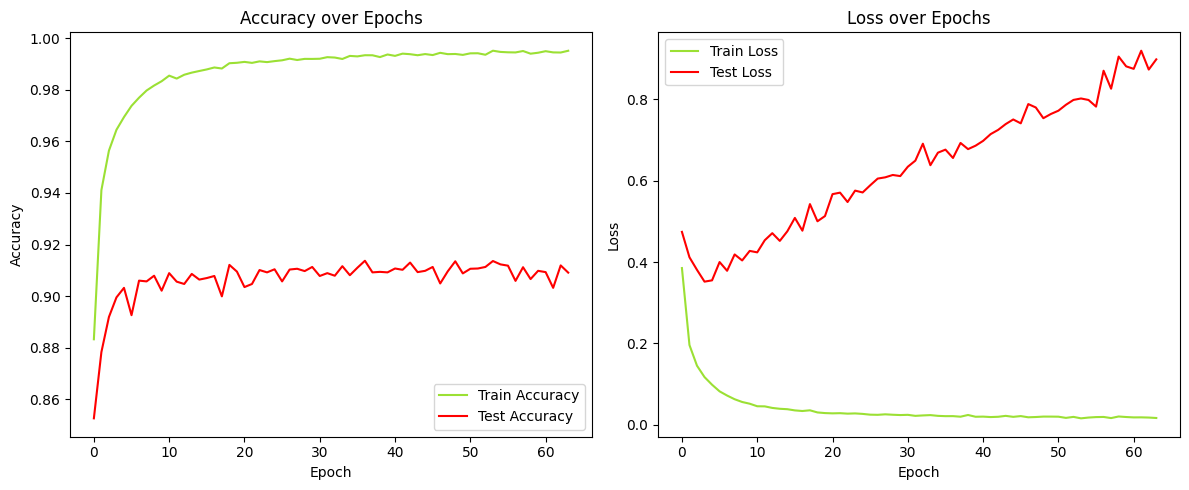

In [18]:
# Get the best accuracy
best_acc = results_MLP_1H['val_accuracy'].max()

print(f'Best grid search accuracy: {best_acc}')

# Get the index for the best run
best_indices = results_MLP_1H.loc[results_MLP_1H['val_accuracy']==best_acc, :].index

if best_indices.shape[0] > 1:
    print(f'Multiple runs with accuracy = {best_acc}. \nBest indices = {best_indices.values}.')
    best_idx = int(input(f'Which index do you want to consider?\nOptions: {best_indices.values}'))
    assert best_idx in best_indices.values, 'Invalid index!'
else:
    best_idx = best_indices[0]

print(f'Best run index: {best_idx}')

# Load the best model
#best_model_path = results_MLP_1H.iloc[best_idx, -1]

#best_MLP_1H = tf.keras.models.load_model(best_model_path)

# Train the best configuration on the training + validation set
## Get the best configuration parameters
best_lr, best_dropout, best_hu, best_optimizer = results_MLP_1H.iloc[best_idx, :4]

best_MLP_1H = build_tf_model_1H(hidden_units= best_hu, dropout= best_dropout, optimizer_name= best_optimizer, lr = best_lr)

early_stop = EarlyStopping(
    monitor='loss',
    min_delta = 0.001,    
    patience=10,            # number of epochs with no improvement after which training will be stopped
    restore_best_weights=True,
    mode = 'min',
    verbose = 1  # restores model weights from the epoch with the best value of the monitored quantity
)

start_time = time.time()

history_MLP_1H = best_MLP_1H.fit(np.vstack((train_images_norm, validation_images_norm)), np.vstack((train_labels, validation_labels)), 
                          epochs = 300,
                          callbacks = [early_stop],
                          validation_data = (test_images_norm, pd.get_dummies(test_labels, dtype= int).to_numpy()))

end_time = time.time()

finalTrain_MLP_1H_time = end_time - start_time
print(f"Total final train time for MLP 1H: {(finalTrain_MLP_1H_time)/60:.2f} minutes")

plot_finalTraining_results(history_MLP_1H)

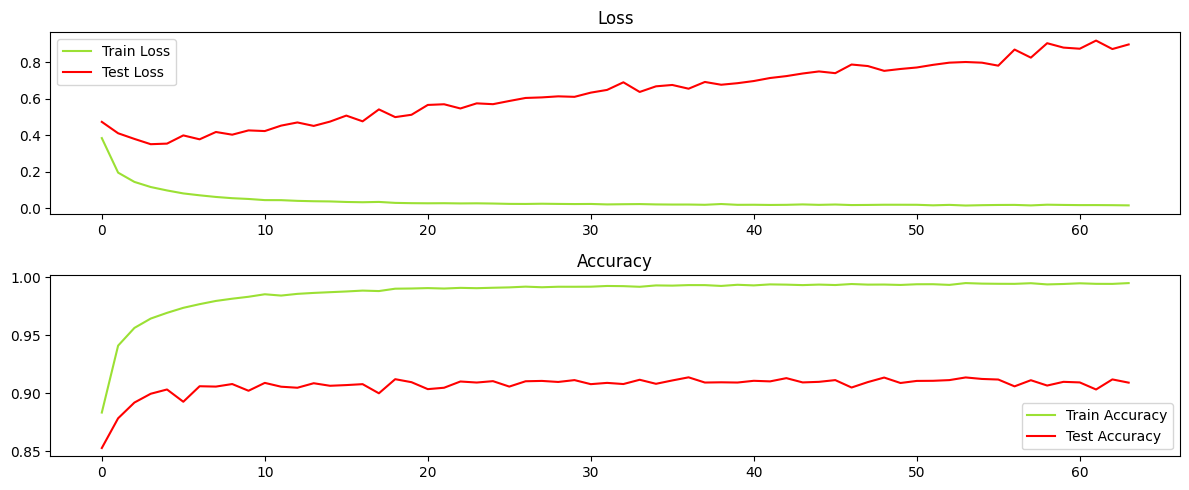

In [32]:
plot_finalTraining_results(history_MLP_1H)

In [23]:
# Save the model after the final training
tf.keras.models.save_model(best_MLP_1H, 'finalModel_MLP_1H.keras')

## 4.2 MLP with 3 hidden layers

Epoch 1/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7303 - loss: 0.8626 - precision: 0.8160 - recall: 0.6618 - val_accuracy: 0.8935 - val_loss: 0.3499 - val_precision: 0.9219 - val_recall: 0.8720
Epoch 2/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8654 - loss: 0.4363 - precision: 0.9005 - recall: 0.8378 - val_accuracy: 0.9277 - val_loss: 0.2406 - val_precision: 0.9464 - val_recall: 0.9132
Epoch 3/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8985 - loss: 0.3333 - precision: 0.9232 - recall: 0.8785 - val_accuracy: 0.9388 - val_loss: 0.2016 - val_precision: 0.9496 - val_recall: 0.9287
Epoch 4/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9169 - loss: 0.2657 - precision: 0.9340 - recall: 0.9031 - val_accuracy: 0.9473 - val_loss: 0.1747 - val_precision: 0.9568 - val_recall: 0.9394
Epoch 5/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9322 - loss: 0.2229 - precision: 0.9459 - recall: 0.9203 - val_accuracy: 0.9559 - va

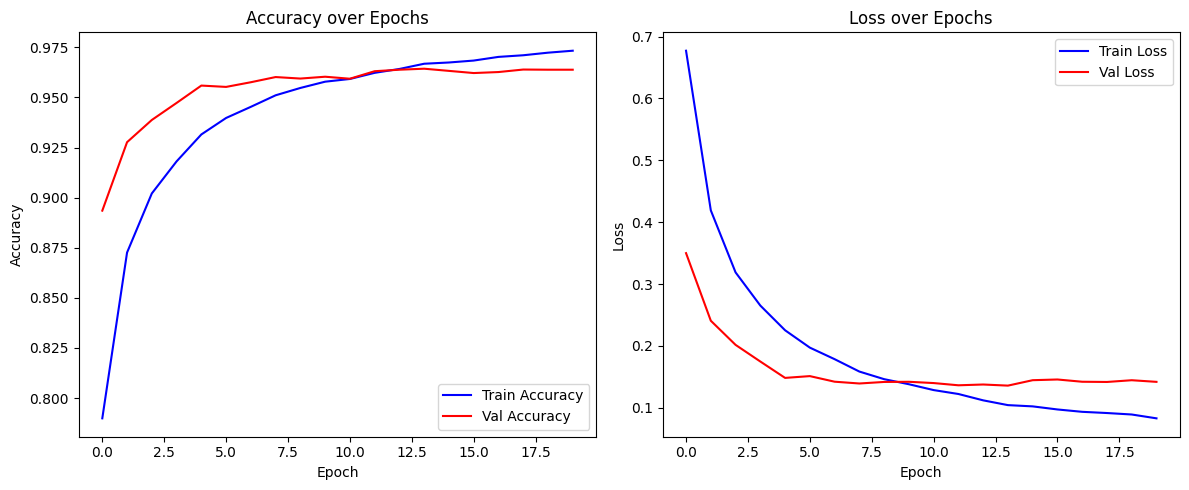

In [18]:
MLP_3H = build_tf_model_3H(256, 256, 64, 0.2, 'adam', 1e-3)

history = MLP_3H.fit(train_images_norm, train_labels, epochs= 20, validation_data=(validation_images_norm, validation_labels))

# Plot losses and accuracy
plot_training_results(history)

### 4.2.1 Conduct a grid search to fine tune some hyperparameters
Test multiple combinations of learning rate, dropout, hidden units (in all three hidden layers) and optimizers

In [10]:
learning_rates = [1e-2, 1e-3, 1e-4, 1e-5]
dropouts = [0.0, 0.2, 0.5]
hidden_neurons = [32, 64, 128, 256]
optimizers_list = ['sgd', 'adam']

# Prepare model saving directory
os.makedirs("mlp3H_saved_models_run2", exist_ok=True)

# Prepare all valid hidden layer combinations with constraint
valid_hidden_configs = [
    (hu1, hu2, hu3)
    for hu1 in hidden_neurons
    for hu2 in hidden_neurons
    for hu3 in hidden_neurons
    if hu2 <= hu1 and hu3 <= hu2
]

# Create the full grid for learning_rate, dropout, optimizer, and hidden layer configs
grid = list(itertools.product(learning_rates, dropouts, valid_hidden_configs, optimizers_list))

results = []
start_time = time.time()

for lr, dr, (hu1, hu2, hu3), opt_name in tqdm(grid, desc="Grid Search Progress"):
    config_name = f"lr{lr}_do{dr}_hu{hu1}_{hu2}_{hu3}_{opt_name}"
    model_path = f"mlp3H_saved_models_run2/best_model_{config_name}.keras"

    print(f"Testing: {config_name}")

    model = build_tf_model_3H(
        hidden_units1=hu1,
        hidden_units2=hu2,
        hidden_units3=hu3,
        dropout=dr,
        optimizer_name=opt_name,
        lr=lr
    )

    checkpoint = tf.keras.callbacks.ModelCheckpoint(
        filepath=model_path,
        monitor='val_accuracy',
        save_best_only=True,
        save_weights_only=False,
        mode='max',
        verbose=0
    )

    early_stop = EarlyStopping(
        monitor='loss',
        min_delta = 0.01,    
        patience=5,            # number of epochs with no improvement after which training will be stopped
        restore_best_weights=True,
        mode = 'min',
        verbose = 1  # restores model weights from the epoch with the best value of the monitored quantity
    )

    history = model.fit(
        train_images_norm,
        train_labels,
        epochs=100,
        validation_data=(validation_images_norm, validation_labels),
        callbacks=[checkpoint, early_stop],
        verbose=0
    )

    try:
        best_model = tf.keras.models.load_model(model_path)
        val_loss, val_acc, val_precision, val_recall = best_model.evaluate(validation_images_norm, validation_labels, verbose=0)

        results.append({
            'learning_rate': lr,
            'dropout': dr,
            'hidden_neurons1': hu1,
            'hidden_neurons2': hu2,
            'hidden_neurons3': hu3,
            'optimizer': opt_name,
            'val_accuracy': val_acc,
            'val_precision': val_precision,
            'val_recall': val_recall,
            'model_path': model_path
        })
    except Exception as e:
        print(f"Failed to evaluate model {config_name}: {e}")

end_time = time.time()
gridSearch_MLP_3H_time = end_time - start_time
print(f"Total grid search time: {(time.time() - start_time)/60:.2f} minutes")

# Save the results of the grid search
with open("mlp3H_grid_search_results_run2.json", "w") as f:
    json.dump(results, f, indent=4)

# Sort and print top 5
results = sorted(results, key=lambda x: x['val_accuracy'], reverse=True)

for r in results[:5]:
    print(r)

Grid Search Progress:   0%|          | 0/480 [00:00<?, ?it/s]

Testing: lr0.01_do0.0_hu32_32_32_sgd
Epoch 38: early stopping
Restoring model weights from the end of the best epoch: 33.


Grid Search Progress:   0%|          | 1/480 [01:15<10:02:38, 75.49s/it]

Testing: lr0.01_do0.0_hu32_32_32_adam
Epoch 31: early stopping
Restoring model weights from the end of the best epoch: 26.


Grid Search Progress:   0%|          | 2/480 [02:25<9:34:47, 72.15s/it] 

Testing: lr0.01_do0.0_hu64_32_32_sgd
Epoch 37: early stopping
Restoring model weights from the end of the best epoch: 32.


Grid Search Progress:   1%|          | 3/480 [03:40<9:45:19, 73.63s/it]

Testing: lr0.01_do0.0_hu64_32_32_adam
Epoch 30: early stopping
Restoring model weights from the end of the best epoch: 25.


Grid Search Progress:   1%|          | 4/480 [04:51<9:35:32, 72.55s/it]

Testing: lr0.01_do0.0_hu64_64_32_sgd
Epoch 36: early stopping
Restoring model weights from the end of the best epoch: 31.


Grid Search Progress:   1%|          | 5/480 [06:04<9:35:12, 72.66s/it]

Testing: lr0.01_do0.0_hu64_64_32_adam
Epoch 33: early stopping
Restoring model weights from the end of the best epoch: 28.


Grid Search Progress:   1%|▏         | 6/480 [07:21<9:46:20, 74.22s/it]

Testing: lr0.01_do0.0_hu64_64_64_sgd
Epoch 37: early stopping
Restoring model weights from the end of the best epoch: 32.


Grid Search Progress:   1%|▏         | 7/480 [08:36<9:46:21, 74.38s/it]

Testing: lr0.01_do0.0_hu64_64_64_adam
Epoch 29: early stopping
Restoring model weights from the end of the best epoch: 24.


Grid Search Progress:   2%|▏         | 8/480 [09:45<9:31:50, 72.69s/it]

Testing: lr0.01_do0.0_hu128_32_32_sgd
Epoch 34: early stopping
Restoring model weights from the end of the best epoch: 29.


Grid Search Progress:   2%|▏         | 9/480 [11:01<9:39:33, 73.83s/it]

Testing: lr0.01_do0.0_hu128_32_32_adam
Epoch 29: early stopping
Restoring model weights from the end of the best epoch: 24.


Grid Search Progress:   2%|▏         | 10/480 [12:18<9:44:24, 74.61s/it]

Testing: lr0.01_do0.0_hu128_64_32_sgd
Epoch 34: early stopping
Restoring model weights from the end of the best epoch: 29.


Grid Search Progress:   2%|▏         | 11/480 [13:34<9:46:26, 75.03s/it]

Testing: lr0.01_do0.0_hu128_64_32_adam
Epoch 30: early stopping
Restoring model weights from the end of the best epoch: 25.


Grid Search Progress:   2%|▎         | 12/480 [14:53<9:55:30, 76.35s/it]

Testing: lr0.01_do0.0_hu128_64_64_sgd
Epoch 30: early stopping
Restoring model weights from the end of the best epoch: 25.


Grid Search Progress:   3%|▎         | 13/480 [16:00<9:32:40, 73.58s/it]

Testing: lr0.01_do0.0_hu128_64_64_adam
Epoch 29: early stopping
Restoring model weights from the end of the best epoch: 24.


Grid Search Progress:   3%|▎         | 14/480 [17:17<9:38:52, 74.53s/it]

Testing: lr0.01_do0.0_hu128_128_32_sgd
Epoch 32: early stopping
Restoring model weights from the end of the best epoch: 27.


Grid Search Progress:   3%|▎         | 15/480 [18:21<9:12:30, 71.29s/it]

Testing: lr0.01_do0.0_hu128_128_32_adam
Epoch 29: early stopping
Restoring model weights from the end of the best epoch: 24.


Grid Search Progress:   3%|▎         | 16/480 [19:36<9:20:25, 72.47s/it]

Testing: lr0.01_do0.0_hu128_128_64_sgd
Epoch 31: early stopping
Restoring model weights from the end of the best epoch: 26.


Grid Search Progress:   4%|▎         | 17/480 [20:44<9:10:06, 71.29s/it]

Testing: lr0.01_do0.0_hu128_128_64_adam
Epoch 25: early stopping
Restoring model weights from the end of the best epoch: 20.


Grid Search Progress:   4%|▍         | 18/480 [22:03<9:24:33, 73.32s/it]

Testing: lr0.01_do0.0_hu128_128_128_sgd
Epoch 28: early stopping
Restoring model weights from the end of the best epoch: 23.


Grid Search Progress:   4%|▍         | 19/480 [23:08<9:04:22, 70.85s/it]

Testing: lr0.01_do0.0_hu128_128_128_adam
Epoch 24: early stopping
Restoring model weights from the end of the best epoch: 19.


Grid Search Progress:   4%|▍         | 20/480 [24:23<9:12:43, 72.09s/it]

Testing: lr0.01_do0.0_hu256_32_32_sgd
Epoch 29: early stopping
Restoring model weights from the end of the best epoch: 24.


Grid Search Progress:   4%|▍         | 21/480 [25:36<9:14:40, 72.51s/it]

Testing: lr0.01_do0.0_hu256_32_32_adam
Epoch 24: early stopping
Restoring model weights from the end of the best epoch: 19.


Grid Search Progress:   5%|▍         | 22/480 [26:57<9:33:05, 75.08s/it]

Testing: lr0.01_do0.0_hu256_64_32_sgd
Epoch 26: early stopping
Restoring model weights from the end of the best epoch: 21.


Grid Search Progress:   5%|▍         | 23/480 [28:05<9:14:33, 72.81s/it]

Testing: lr0.01_do0.0_hu256_64_32_adam
Epoch 28: early stopping
Restoring model weights from the end of the best epoch: 23.


Grid Search Progress:   5%|▌         | 24/480 [29:42<10:08:51, 80.11s/it]

Testing: lr0.01_do0.0_hu256_64_64_sgd
Epoch 24: early stopping
Restoring model weights from the end of the best epoch: 19.


Grid Search Progress:   5%|▌         | 25/480 [30:44<9:26:41, 74.73s/it] 

Testing: lr0.01_do0.0_hu256_64_64_adam
Epoch 30: early stopping
Restoring model weights from the end of the best epoch: 25.


Grid Search Progress:   5%|▌         | 26/480 [32:29<10:33:36, 83.74s/it]

Testing: lr0.01_do0.0_hu256_128_32_sgd
Epoch 26: early stopping
Restoring model weights from the end of the best epoch: 21.


Grid Search Progress:   6%|▌         | 27/480 [33:37<9:57:56, 79.20s/it] 

Testing: lr0.01_do0.0_hu256_128_32_adam
Epoch 22: early stopping
Restoring model weights from the end of the best epoch: 17.


Grid Search Progress:   6%|▌         | 28/480 [35:01<10:07:48, 80.68s/it]

Testing: lr0.01_do0.0_hu256_128_64_sgd
Epoch 22: early stopping
Restoring model weights from the end of the best epoch: 17.


Grid Search Progress:   6%|▌         | 29/480 [36:03<9:24:02, 75.04s/it] 

Testing: lr0.01_do0.0_hu256_128_64_adam
Epoch 28: early stopping
Restoring model weights from the end of the best epoch: 23.


Grid Search Progress:   6%|▋         | 30/480 [37:48<10:29:53, 83.99s/it]

Testing: lr0.01_do0.0_hu256_128_128_sgd
Epoch 23: early stopping
Restoring model weights from the end of the best epoch: 18.


Grid Search Progress:   6%|▋         | 31/480 [38:54<9:47:29, 78.51s/it] 

Testing: lr0.01_do0.0_hu256_128_128_adam
Epoch 30: early stopping
Restoring model weights from the end of the best epoch: 25.


Grid Search Progress:   7%|▋         | 32/480 [40:46<11:01:19, 88.57s/it]

Testing: lr0.01_do0.0_hu256_256_32_sgd
Epoch 23: early stopping
Restoring model weights from the end of the best epoch: 18.


Grid Search Progress:   7%|▋         | 33/480 [41:51<10:06:24, 81.40s/it]

Testing: lr0.01_do0.0_hu256_256_32_adam
Epoch 25: early stopping
Restoring model weights from the end of the best epoch: 20.


Grid Search Progress:   7%|▋         | 34/480 [43:24<10:31:24, 84.94s/it]

Testing: lr0.01_do0.0_hu256_256_64_sgd
Epoch 24: early stopping
Restoring model weights from the end of the best epoch: 19.


Grid Search Progress:   7%|▋         | 35/480 [44:33<9:54:14, 80.12s/it] 

Testing: lr0.01_do0.0_hu256_256_64_adam
Epoch 25: early stopping
Restoring model weights from the end of the best epoch: 20.


Grid Search Progress:   8%|▊         | 36/480 [46:07<10:25:12, 84.49s/it]

Testing: lr0.01_do0.0_hu256_256_128_sgd
Epoch 25: early stopping
Restoring model weights from the end of the best epoch: 20.


Grid Search Progress:   8%|▊         | 37/480 [47:21<9:59:08, 81.15s/it] 

Testing: lr0.01_do0.0_hu256_256_128_adam
Epoch 28: early stopping
Restoring model weights from the end of the best epoch: 23.


Grid Search Progress:   8%|▊         | 38/480 [49:09<10:56:35, 89.13s/it]

Testing: lr0.01_do0.0_hu256_256_256_sgd
Epoch 25: early stopping
Restoring model weights from the end of the best epoch: 20.


Grid Search Progress:   8%|▊         | 39/480 [50:34<10:46:11, 87.92s/it]

Testing: lr0.01_do0.0_hu256_256_256_adam
Epoch 27: early stopping
Restoring model weights from the end of the best epoch: 22.


Grid Search Progress:   8%|▊         | 40/480 [52:30<11:47:21, 96.46s/it]

Testing: lr0.01_do0.2_hu32_32_32_sgd
Epoch 34: early stopping
Restoring model weights from the end of the best epoch: 29.


Grid Search Progress:   9%|▊         | 41/480 [53:37<10:41:10, 87.63s/it]

Testing: lr0.01_do0.2_hu32_32_32_adam
Epoch 24: early stopping
Restoring model weights from the end of the best epoch: 19.


Grid Search Progress:   9%|▉         | 42/480 [54:32<9:28:13, 77.84s/it] 

Testing: lr0.01_do0.2_hu64_32_32_sgd
Epoch 44: early stopping
Restoring model weights from the end of the best epoch: 39.


Grid Search Progress:   9%|▉         | 43/480 [56:00<9:48:26, 80.79s/it]

Testing: lr0.01_do0.2_hu64_32_32_adam
Epoch 34: early stopping
Restoring model weights from the end of the best epoch: 29.


Grid Search Progress:   9%|▉         | 44/480 [57:18<9:40:58, 79.95s/it]

Testing: lr0.01_do0.2_hu64_64_32_sgd
Epoch 34: early stopping
Restoring model weights from the end of the best epoch: 29.


Grid Search Progress:   9%|▉         | 45/480 [58:26<9:14:22, 76.47s/it]

Testing: lr0.01_do0.2_hu64_64_32_adam
Epoch 27: early stopping
Restoring model weights from the end of the best epoch: 22.


Grid Search Progress:  10%|▉         | 46/480 [59:30<8:45:29, 72.65s/it]

Testing: lr0.01_do0.2_hu64_64_64_sgd
Epoch 35: early stopping
Restoring model weights from the end of the best epoch: 30.


Grid Search Progress:  10%|▉         | 47/480 [1:00:40<8:39:14, 71.95s/it]

Testing: lr0.01_do0.2_hu64_64_64_adam
Epoch 38: early stopping
Restoring model weights from the end of the best epoch: 33.


Grid Search Progress:  10%|█         | 48/480 [1:02:10<9:16:42, 77.32s/it]

Testing: lr0.01_do0.2_hu128_32_32_sgd
Epoch 40: early stopping
Restoring model weights from the end of the best epoch: 35.


Grid Search Progress:  10%|█         | 49/480 [1:03:35<9:32:43, 79.73s/it]

Testing: lr0.01_do0.2_hu128_32_32_adam
Epoch 24: early stopping
Restoring model weights from the end of the best epoch: 19.


Grid Search Progress:  10%|█         | 50/480 [1:04:44<9:08:16, 76.50s/it]

Testing: lr0.01_do0.2_hu128_64_32_sgd
Epoch 47: early stopping
Restoring model weights from the end of the best epoch: 42.


Grid Search Progress:  11%|█         | 51/480 [1:06:32<10:14:59, 86.01s/it]

Testing: lr0.01_do0.2_hu128_64_32_adam
Epoch 31: early stopping
Restoring model weights from the end of the best epoch: 26.


Grid Search Progress:  11%|█         | 52/480 [1:08:07<10:31:43, 88.56s/it]

Testing: lr0.01_do0.2_hu128_64_64_sgd
Epoch 46: early stopping
Restoring model weights from the end of the best epoch: 41.


Grid Search Progress:  11%|█         | 53/480 [1:09:52<11:05:20, 93.49s/it]

Testing: lr0.01_do0.2_hu128_64_64_adam
Epoch 32: early stopping
Restoring model weights from the end of the best epoch: 27.


Grid Search Progress:  11%|█▏        | 54/480 [1:11:31<11:15:18, 95.11s/it]

Testing: lr0.01_do0.2_hu128_128_32_sgd
Epoch 45: early stopping
Restoring model weights from the end of the best epoch: 40.


Grid Search Progress:  11%|█▏        | 55/480 [1:13:14<11:30:11, 97.44s/it]

Testing: lr0.01_do0.2_hu128_128_32_adam
Epoch 37: early stopping
Restoring model weights from the end of the best epoch: 32.


Grid Search Progress:  12%|█▏        | 56/480 [1:15:05<11:58:43, 101.71s/it]

Testing: lr0.01_do0.2_hu128_128_64_sgd
Epoch 46: early stopping
Restoring model weights from the end of the best epoch: 41.


Grid Search Progress:  12%|█▏        | 57/480 [1:16:50<12:02:57, 102.55s/it]

Testing: lr0.01_do0.2_hu128_128_64_adam
Epoch 34: early stopping
Restoring model weights from the end of the best epoch: 29.


Grid Search Progress:  12%|█▏        | 58/480 [1:18:34<12:04:35, 103.02s/it]

Testing: lr0.01_do0.2_hu128_128_128_sgd
Epoch 34: early stopping
Restoring model weights from the end of the best epoch: 29.


Grid Search Progress:  12%|█▏        | 59/480 [1:19:54<11:13:37, 96.00s/it] 

Testing: lr0.01_do0.2_hu128_128_128_adam
Epoch 34: early stopping
Restoring model weights from the end of the best epoch: 29.


Grid Search Progress:  12%|█▎        | 60/480 [1:21:40<11:34:44, 99.25s/it]

Testing: lr0.01_do0.2_hu256_32_32_sgd
Epoch 38: early stopping
Restoring model weights from the end of the best epoch: 33.


Grid Search Progress:  13%|█▎        | 61/480 [1:23:16<11:24:37, 98.04s/it]

Testing: lr0.01_do0.2_hu256_32_32_adam
Epoch 39: early stopping
Restoring model weights from the end of the best epoch: 34.


Grid Search Progress:  13%|█▎        | 62/480 [1:25:28<12:34:16, 108.27s/it]

Testing: lr0.01_do0.2_hu256_64_32_sgd
Epoch 43: early stopping
Restoring model weights from the end of the best epoch: 38.


Grid Search Progress:  13%|█▎        | 63/480 [1:27:18<12:37:13, 108.95s/it]

Testing: lr0.01_do0.2_hu256_64_32_adam
Epoch 33: early stopping
Restoring model weights from the end of the best epoch: 28.


Grid Search Progress:  13%|█▎        | 64/480 [1:29:13<12:47:57, 110.76s/it]

Testing: lr0.01_do0.2_hu256_64_64_sgd
Epoch 35: early stopping
Restoring model weights from the end of the best epoch: 30.


Grid Search Progress:  14%|█▎        | 65/480 [1:30:52<12:21:01, 107.14s/it]

Testing: lr0.01_do0.2_hu256_64_64_adam
Epoch 36: early stopping
Restoring model weights from the end of the best epoch: 31.


Grid Search Progress:  14%|█▍        | 66/480 [1:33:08<13:18:05, 115.67s/it]

Testing: lr0.01_do0.2_hu256_128_32_sgd
Epoch 40: early stopping
Restoring model weights from the end of the best epoch: 35.


Grid Search Progress:  14%|█▍        | 67/480 [1:35:03<13:14:47, 115.47s/it]

Testing: lr0.01_do0.2_hu256_128_32_adam
Epoch 32: early stopping
Restoring model weights from the end of the best epoch: 27.


Grid Search Progress:  14%|█▍        | 68/480 [1:37:02<13:21:32, 116.73s/it]

Testing: lr0.01_do0.2_hu256_128_64_sgd
Epoch 47: early stopping
Restoring model weights from the end of the best epoch: 42.


Grid Search Progress:  14%|█▍        | 69/480 [1:39:14<13:50:22, 121.22s/it]

Testing: lr0.01_do0.2_hu256_128_64_adam
Epoch 29: early stopping
Restoring model weights from the end of the best epoch: 24.


Grid Search Progress:  15%|█▍        | 70/480 [1:40:58<13:13:03, 116.06s/it]

Testing: lr0.01_do0.2_hu256_128_128_sgd
Epoch 42: early stopping
Restoring model weights from the end of the best epoch: 37.


Grid Search Progress:  15%|█▍        | 71/480 [1:42:57<13:16:50, 116.90s/it]

Testing: lr0.01_do0.2_hu256_128_128_adam
Epoch 26: early stopping
Restoring model weights from the end of the best epoch: 21.


Grid Search Progress:  15%|█▌        | 72/480 [1:44:35<12:36:03, 111.18s/it]

Testing: lr0.01_do0.2_hu256_256_32_sgd
Epoch 38: early stopping
Restoring model weights from the end of the best epoch: 33.


Grid Search Progress:  15%|█▌        | 73/480 [1:46:23<12:28:12, 110.30s/it]

Testing: lr0.01_do0.2_hu256_256_32_adam
Epoch 34: early stopping
Restoring model weights from the end of the best epoch: 29.


Grid Search Progress:  15%|█▌        | 74/480 [1:48:31<13:02:50, 115.69s/it]

Testing: lr0.01_do0.2_hu256_256_64_sgd
Epoch 39: early stopping
Restoring model weights from the end of the best epoch: 34.


Grid Search Progress:  16%|█▌        | 75/480 [1:50:23<12:53:44, 114.63s/it]

Testing: lr0.01_do0.2_hu256_256_64_adam
Epoch 32: early stopping
Restoring model weights from the end of the best epoch: 27.


Grid Search Progress:  16%|█▌        | 76/480 [1:52:25<13:05:57, 116.73s/it]

Testing: lr0.01_do0.2_hu256_256_128_sgd
Epoch 39: early stopping
Restoring model weights from the end of the best epoch: 34.


Grid Search Progress:  16%|█▌        | 77/480 [1:54:24<13:09:20, 117.52s/it]

Testing: lr0.01_do0.2_hu256_256_128_adam
Epoch 33: early stopping
Restoring model weights from the end of the best epoch: 28.


Grid Search Progress:  16%|█▋        | 78/480 [1:56:34<13:32:17, 121.24s/it]

Testing: lr0.01_do0.2_hu256_256_256_sgd
Epoch 36: early stopping
Restoring model weights from the end of the best epoch: 31.


Grid Search Progress:  16%|█▋        | 79/480 [1:58:32<13:22:59, 120.15s/it]

Testing: lr0.01_do0.2_hu256_256_256_adam
Epoch 29: early stopping
Restoring model weights from the end of the best epoch: 24.


Grid Search Progress:  17%|█▋        | 80/480 [2:00:43<13:43:39, 123.55s/it]

Testing: lr0.01_do0.5_hu32_32_32_sgd
Epoch 37: early stopping
Restoring model weights from the end of the best epoch: 32.


Grid Search Progress:  17%|█▋        | 81/480 [2:01:57<12:01:11, 108.45s/it]

Testing: lr0.01_do0.5_hu32_32_32_adam
Epoch 27: early stopping
Restoring model weights from the end of the best epoch: 22.


Grid Search Progress:  17%|█▋        | 82/480 [2:02:58<10:25:35, 94.31s/it] 

Testing: lr0.01_do0.5_hu64_32_32_sgd
Epoch 42: early stopping
Restoring model weights from the end of the best epoch: 37.


Grid Search Progress:  17%|█▋        | 83/480 [2:04:23<10:06:09, 91.61s/it]

Testing: lr0.01_do0.5_hu64_32_32_adam
Epoch 26: early stopping
Restoring model weights from the end of the best epoch: 21.


Grid Search Progress:  18%|█▊        | 84/480 [2:05:27<9:09:33, 83.27s/it] 

Testing: lr0.01_do0.5_hu64_64_32_sgd
Epoch 33: early stopping
Restoring model weights from the end of the best epoch: 28.


Grid Search Progress:  18%|█▊        | 85/480 [2:06:36<8:39:36, 78.93s/it]

Testing: lr0.01_do0.5_hu64_64_32_adam
Epoch 32: early stopping
Restoring model weights from the end of the best epoch: 27.


Grid Search Progress:  18%|█▊        | 86/480 [2:07:54<8:36:42, 78.69s/it]

Testing: lr0.01_do0.5_hu64_64_64_sgd
Epoch 46: early stopping
Restoring model weights from the end of the best epoch: 41.


Grid Search Progress:  18%|█▊        | 87/480 [2:09:28<9:04:44, 83.17s/it]

Testing: lr0.01_do0.5_hu64_64_64_adam
Epoch 31: early stopping
Restoring model weights from the end of the best epoch: 26.


Grid Search Progress:  18%|█▊        | 88/480 [2:10:42<8:45:34, 80.44s/it]

Testing: lr0.01_do0.5_hu128_32_32_sgd
Epoch 51: early stopping
Restoring model weights from the end of the best epoch: 46.


Grid Search Progress:  19%|█▊        | 89/480 [2:12:31<9:40:34, 89.09s/it]

Testing: lr0.01_do0.5_hu128_32_32_adam
Epoch 36: early stopping
Restoring model weights from the end of the best epoch: 31.


Grid Search Progress:  19%|█▉        | 90/480 [2:14:15<10:08:30, 93.62s/it]

Testing: lr0.01_do0.5_hu128_64_32_sgd
Epoch 55: early stopping
Restoring model weights from the end of the best epoch: 50.


Grid Search Progress:  19%|█▉        | 91/480 [2:16:14<10:56:35, 101.27s/it]

Testing: lr0.01_do0.5_hu128_64_32_adam
Epoch 33: early stopping
Restoring model weights from the end of the best epoch: 28.


Grid Search Progress:  19%|█▉        | 92/480 [2:17:51<10:46:20, 99.95s/it] 

Testing: lr0.01_do0.5_hu128_64_64_sgd
Epoch 42: early stopping
Restoring model weights from the end of the best epoch: 37.


Grid Search Progress:  19%|█▉        | 93/480 [2:19:25<10:32:34, 98.07s/it]

Testing: lr0.01_do0.5_hu128_64_64_adam
Epoch 36: early stopping
Restoring model weights from the end of the best epoch: 31.


Grid Search Progress:  20%|█▉        | 94/480 [2:21:13<10:50:44, 101.15s/it]

Testing: lr0.01_do0.5_hu128_128_32_sgd
Epoch 47: early stopping
Restoring model weights from the end of the best epoch: 42.


Grid Search Progress:  20%|█▉        | 95/480 [2:22:58<10:56:11, 102.26s/it]

Testing: lr0.01_do0.5_hu128_128_32_adam
Epoch 40: early stopping
Restoring model weights from the end of the best epoch: 35.


Grid Search Progress:  20%|██        | 96/480 [2:25:08<11:46:57, 110.46s/it]

Testing: lr0.01_do0.5_hu128_128_64_sgd
Epoch 46: early stopping
Restoring model weights from the end of the best epoch: 41.


Grid Search Progress:  20%|██        | 97/480 [2:26:59<11:47:23, 110.82s/it]

Testing: lr0.01_do0.5_hu128_128_64_adam
Epoch 28: early stopping
Restoring model weights from the end of the best epoch: 23.


Grid Search Progress:  20%|██        | 98/480 [2:28:30<11:07:40, 104.87s/it]

Testing: lr0.01_do0.5_hu128_128_128_sgd
Epoch 53: early stopping
Restoring model weights from the end of the best epoch: 48.


Grid Search Progress:  21%|██        | 99/480 [2:30:43<11:58:09, 113.10s/it]

Testing: lr0.01_do0.5_hu128_128_128_adam
Epoch 37: early stopping
Restoring model weights from the end of the best epoch: 32.


Grid Search Progress:  21%|██        | 100/480 [2:32:45<12:14:41, 116.00s/it]

Testing: lr0.01_do0.5_hu256_32_32_sgd
Epoch 43: early stopping
Restoring model weights from the end of the best epoch: 38.


Grid Search Progress:  21%|██        | 101/480 [2:34:40<12:09:39, 115.51s/it]

Testing: lr0.01_do0.5_hu256_32_32_adam
Epoch 39: early stopping
Restoring model weights from the end of the best epoch: 34.


Grid Search Progress:  21%|██▏       | 102/480 [2:36:57<12:49:25, 122.13s/it]

Testing: lr0.01_do0.5_hu256_64_32_sgd
Epoch 56: early stopping
Restoring model weights from the end of the best epoch: 51.


Grid Search Progress:  21%|██▏       | 103/480 [2:39:26<13:38:07, 130.21s/it]

Testing: lr0.01_do0.5_hu256_64_32_adam
Epoch 43: early stopping
Restoring model weights from the end of the best epoch: 38.


Grid Search Progress:  22%|██▏       | 104/480 [2:41:58<14:17:02, 136.76s/it]

Testing: lr0.01_do0.5_hu256_64_64_sgd
Epoch 44: early stopping
Restoring model weights from the end of the best epoch: 39.


Grid Search Progress:  22%|██▏       | 105/480 [2:43:55<13:36:13, 130.60s/it]

Testing: lr0.01_do0.5_hu256_64_64_adam
Epoch 29: early stopping
Restoring model weights from the end of the best epoch: 24.


Grid Search Progress:  22%|██▏       | 106/480 [2:45:39<12:44:53, 122.71s/it]

Testing: lr0.01_do0.5_hu256_128_32_sgd
Epoch 48: early stopping
Restoring model weights from the end of the best epoch: 43.


Grid Search Progress:  22%|██▏       | 107/480 [2:47:50<12:58:27, 125.22s/it]

Testing: lr0.01_do0.5_hu256_128_32_adam
Epoch 37: early stopping
Restoring model weights from the end of the best epoch: 32.


Grid Search Progress:  22%|██▎       | 108/480 [2:50:04<13:12:18, 127.79s/it]

Testing: lr0.01_do0.5_hu256_128_64_sgd
Epoch 57: early stopping
Restoring model weights from the end of the best epoch: 52.


Grid Search Progress:  23%|██▎       | 109/480 [2:52:41<14:04:55, 136.64s/it]

Testing: lr0.01_do0.5_hu256_128_64_adam
Epoch 40: early stopping
Restoring model weights from the end of the best epoch: 35.


Grid Search Progress:  23%|██▎       | 110/480 [2:55:06<14:18:38, 139.24s/it]

Testing: lr0.01_do0.5_hu256_128_128_sgd
Epoch 50: early stopping
Restoring model weights from the end of the best epoch: 45.


Grid Search Progress:  23%|██▎       | 111/480 [2:57:28<14:21:31, 140.08s/it]

Testing: lr0.01_do0.5_hu256_128_128_adam
Epoch 35: early stopping
Restoring model weights from the end of the best epoch: 30.


Grid Search Progress:  23%|██▎       | 112/480 [2:59:41<14:05:18, 137.82s/it]

Testing: lr0.01_do0.5_hu256_256_32_sgd
Epoch 48: early stopping
Restoring model weights from the end of the best epoch: 43.


Grid Search Progress:  24%|██▎       | 113/480 [3:01:58<14:01:49, 137.63s/it]

Testing: lr0.01_do0.5_hu256_256_32_adam
Epoch 30: early stopping
Restoring model weights from the end of the best epoch: 25.


Grid Search Progress:  24%|██▍       | 114/480 [3:04:04<13:38:51, 134.24s/it]

Testing: lr0.01_do0.5_hu256_256_64_sgd
Epoch 49: early stopping
Restoring model weights from the end of the best epoch: 44.


Grid Search Progress:  24%|██▍       | 115/480 [3:06:47<14:28:15, 142.73s/it]

Testing: lr0.01_do0.5_hu256_256_64_adam
Epoch 39: early stopping
Restoring model weights from the end of the best epoch: 34.


Grid Search Progress:  24%|██▍       | 116/480 [3:09:32<15:05:41, 149.29s/it]

Testing: lr0.01_do0.5_hu256_256_128_sgd
Epoch 50: early stopping
Restoring model weights from the end of the best epoch: 45.


Grid Search Progress:  24%|██▍       | 117/480 [3:12:24<15:45:31, 156.28s/it]

Testing: lr0.01_do0.5_hu256_256_128_adam
Epoch 44: early stopping
Restoring model weights from the end of the best epoch: 39.


Grid Search Progress:  25%|██▍       | 118/480 [3:15:36<16:46:44, 166.86s/it]

Testing: lr0.01_do0.5_hu256_256_256_sgd
Epoch 46: early stopping
Restoring model weights from the end of the best epoch: 41.


Grid Search Progress:  25%|██▍       | 119/480 [3:18:17<16:34:21, 165.27s/it]

Testing: lr0.01_do0.5_hu256_256_256_adam
Epoch 36: early stopping
Restoring model weights from the end of the best epoch: 31.


Grid Search Progress:  25%|██▌       | 120/480 [3:20:59<16:24:33, 164.09s/it]

Testing: lr0.001_do0.0_hu32_32_32_sgd
Epoch 58: early stopping
Restoring model weights from the end of the best epoch: 53.


Grid Search Progress:  25%|██▌       | 121/480 [3:22:50<14:47:16, 148.29s/it]

Testing: lr0.001_do0.0_hu32_32_32_adam
Epoch 33: early stopping
Restoring model weights from the end of the best epoch: 28.


Grid Search Progress:  25%|██▌       | 122/480 [3:24:01<12:26:48, 125.16s/it]

Testing: lr0.001_do0.0_hu64_32_32_sgd
Epoch 50: early stopping
Restoring model weights from the end of the best epoch: 45.


Grid Search Progress:  26%|██▌       | 123/480 [3:25:42<11:40:48, 117.78s/it]

Testing: lr0.001_do0.0_hu64_32_32_adam
Epoch 29: early stopping
Restoring model weights from the end of the best epoch: 24.


Grid Search Progress:  26%|██▌       | 124/480 [3:26:47<10:05:46, 102.10s/it]

Testing: lr0.001_do0.0_hu64_64_32_sgd
Epoch 58: early stopping
Restoring model weights from the end of the best epoch: 53.


Grid Search Progress:  26%|██▌       | 125/480 [3:28:44<10:29:30, 106.40s/it]

Testing: lr0.001_do0.0_hu64_64_32_adam
Epoch 28: early stopping
Restoring model weights from the end of the best epoch: 23.


Grid Search Progress:  26%|██▋       | 126/480 [3:29:47<9:12:08, 93.58s/it]  

Testing: lr0.001_do0.0_hu64_64_64_sgd
Epoch 66: early stopping
Restoring model weights from the end of the best epoch: 61.


Grid Search Progress:  26%|██▋       | 127/480 [3:31:59<10:18:26, 105.12s/it]

Testing: lr0.001_do0.0_hu64_64_64_adam
Epoch 27: early stopping
Restoring model weights from the end of the best epoch: 22.


Grid Search Progress:  27%|██▋       | 128/480 [3:33:03<9:02:51, 92.53s/it]  

Testing: lr0.001_do0.0_hu128_32_32_sgd
Epoch 65: early stopping
Restoring model weights from the end of the best epoch: 60.


Grid Search Progress:  27%|██▋       | 129/480 [3:35:20<10:20:24, 106.05s/it]

Testing: lr0.001_do0.0_hu128_32_32_adam
Epoch 23: early stopping
Restoring model weights from the end of the best epoch: 18.


Grid Search Progress:  27%|██▋       | 130/480 [3:36:25<9:06:31, 93.69s/it]  

Testing: lr0.001_do0.0_hu128_64_32_sgd
Epoch 58: early stopping
Restoring model weights from the end of the best epoch: 53.


Grid Search Progress:  27%|██▋       | 131/480 [3:38:30<9:58:45, 102.94s/it]

Testing: lr0.001_do0.0_hu128_64_32_adam
Epoch 24: early stopping
Restoring model weights from the end of the best epoch: 19.


Grid Search Progress:  28%|██▊       | 132/480 [3:39:38<8:57:20, 92.65s/it] 

Testing: lr0.001_do0.0_hu128_64_64_sgd
Epoch 61: early stopping
Restoring model weights from the end of the best epoch: 56.


Grid Search Progress:  28%|██▊       | 133/480 [3:41:51<10:05:18, 104.67s/it]

Testing: lr0.001_do0.0_hu128_64_64_adam
Epoch 22: early stopping
Restoring model weights from the end of the best epoch: 17.


Grid Search Progress:  28%|██▊       | 134/480 [3:42:54<8:52:22, 92.32s/it]  

Testing: lr0.001_do0.0_hu128_128_32_sgd
Epoch 58: early stopping
Restoring model weights from the end of the best epoch: 53.


Grid Search Progress:  28%|██▊       | 135/480 [3:45:01<9:50:11, 102.64s/it]

Testing: lr0.001_do0.0_hu128_128_32_adam
Epoch 23: early stopping
Restoring model weights from the end of the best epoch: 18.


Grid Search Progress:  28%|██▊       | 136/480 [3:46:18<9:03:34, 94.81s/it] 

Testing: lr0.001_do0.0_hu128_128_64_sgd
Epoch 54: early stopping
Restoring model weights from the end of the best epoch: 49.


Grid Search Progress:  29%|██▊       | 137/480 [3:48:28<10:02:42, 105.43s/it]

Testing: lr0.001_do0.0_hu128_128_64_adam
Epoch 25: early stopping
Restoring model weights from the end of the best epoch: 20.


Grid Search Progress:  29%|██▉       | 138/480 [3:49:50<9:21:30, 98.51s/it]  

Testing: lr0.001_do0.0_hu128_128_128_sgd
Epoch 60: early stopping
Restoring model weights from the end of the best epoch: 55.


Grid Search Progress:  29%|██▉       | 139/480 [3:52:18<10:44:34, 113.41s/it]

Testing: lr0.001_do0.0_hu128_128_128_adam
Epoch 25: early stopping
Restoring model weights from the end of the best epoch: 20.


Grid Search Progress:  29%|██▉       | 140/480 [3:53:42<9:52:09, 104.50s/it] 

Testing: lr0.001_do0.0_hu256_32_32_sgd
Epoch 65: early stopping
Restoring model weights from the end of the best epoch: 60.


Grid Search Progress:  29%|██▉       | 141/480 [3:56:34<11:45:19, 124.84s/it]

Testing: lr0.001_do0.0_hu256_32_32_adam
Epoch 26: early stopping
Restoring model weights from the end of the best epoch: 21.


Grid Search Progress:  30%|██▉       | 142/480 [3:58:08<10:50:36, 115.49s/it]

Testing: lr0.001_do0.0_hu256_64_32_sgd
Epoch 59: early stopping
Restoring model weights from the end of the best epoch: 54.


Grid Search Progress:  30%|██▉       | 143/480 [4:00:45<11:59:12, 128.05s/it]

Testing: lr0.001_do0.0_hu256_64_32_adam
Epoch 21: early stopping
Restoring model weights from the end of the best epoch: 16.


Grid Search Progress:  30%|███       | 144/480 [4:02:02<10:30:29, 112.59s/it]

Testing: lr0.001_do0.0_hu256_64_64_sgd
Epoch 56: early stopping
Restoring model weights from the end of the best epoch: 51.


Grid Search Progress:  30%|███       | 145/480 [4:04:31<11:29:07, 123.42s/it]

Testing: lr0.001_do0.0_hu256_64_64_adam
Epoch 20: early stopping
Restoring model weights from the end of the best epoch: 15.


Grid Search Progress:  30%|███       | 146/480 [4:05:43<10:02:28, 108.23s/it]

Testing: lr0.001_do0.0_hu256_128_32_sgd
Epoch 67: early stopping
Restoring model weights from the end of the best epoch: 62.


Grid Search Progress:  31%|███       | 147/480 [4:08:45<12:03:23, 130.34s/it]

Testing: lr0.001_do0.0_hu256_128_32_adam
Epoch 26: early stopping
Restoring model weights from the end of the best epoch: 21.


Grid Search Progress:  31%|███       | 148/480 [4:10:19<11:00:26, 119.36s/it]

Testing: lr0.001_do0.0_hu256_128_64_sgd
Epoch 56: early stopping
Restoring model weights from the end of the best epoch: 51.


Grid Search Progress:  31%|███       | 149/480 [4:12:51<11:52:14, 129.11s/it]

Testing: lr0.001_do0.0_hu256_128_64_adam
Epoch 23: early stopping
Restoring model weights from the end of the best epoch: 18.


Grid Search Progress:  31%|███▏      | 150/480 [4:14:15<10:35:48, 115.60s/it]

Testing: lr0.001_do0.0_hu256_128_128_sgd
Epoch 50: early stopping
Restoring model weights from the end of the best epoch: 45.


Grid Search Progress:  31%|███▏      | 151/480 [4:16:35<11:13:46, 122.88s/it]

Testing: lr0.001_do0.0_hu256_128_128_adam
Epoch 23: early stopping
Restoring model weights from the end of the best epoch: 18.


Grid Search Progress:  32%|███▏      | 152/480 [4:18:02<10:13:19, 112.19s/it]

Testing: lr0.001_do0.0_hu256_256_32_sgd
Epoch 61: early stopping
Restoring model weights from the end of the best epoch: 56.


Grid Search Progress:  32%|███▏      | 153/480 [4:20:55<11:50:02, 130.28s/it]

Testing: lr0.001_do0.0_hu256_256_32_adam
Epoch 24: early stopping
Restoring model weights from the end of the best epoch: 19.


Grid Search Progress:  32%|███▏      | 154/480 [4:22:24<10:41:38, 118.09s/it]

Testing: lr0.001_do0.0_hu256_256_64_sgd
Epoch 62: early stopping
Restoring model weights from the end of the best epoch: 57.


Grid Search Progress:  32%|███▏      | 155/480 [4:25:20<12:14:00, 135.51s/it]

Testing: lr0.001_do0.0_hu256_256_64_adam
Epoch 20: early stopping
Restoring model weights from the end of the best epoch: 15.


Grid Search Progress:  32%|███▎      | 156/480 [4:26:39<10:38:48, 118.30s/it]

Testing: lr0.001_do0.0_hu256_256_128_sgd
Epoch 54: early stopping
Restoring model weights from the end of the best epoch: 49.


Grid Search Progress:  33%|███▎      | 157/480 [4:29:19<11:44:20, 130.84s/it]

Testing: lr0.001_do0.0_hu256_256_128_adam
Epoch 21: early stopping
Restoring model weights from the end of the best epoch: 16.


Grid Search Progress:  33%|███▎      | 158/480 [4:30:41<10:24:03, 116.28s/it]

Testing: lr0.001_do0.0_hu256_256_256_sgd
Epoch 48: early stopping
Restoring model weights from the end of the best epoch: 43.


Grid Search Progress:  33%|███▎      | 159/480 [4:33:14<11:21:10, 127.32s/it]

Testing: lr0.001_do0.0_hu256_256_256_adam
Epoch 20: early stopping
Restoring model weights from the end of the best epoch: 15.


Grid Search Progress:  33%|███▎      | 160/480 [4:34:49<10:26:35, 117.49s/it]

Testing: lr0.001_do0.2_hu32_32_32_sgd
Epoch 60: early stopping
Restoring model weights from the end of the best epoch: 55.


Grid Search Progress:  34%|███▎      | 161/480 [4:36:55<10:39:28, 120.28s/it]

Testing: lr0.001_do0.2_hu32_32_32_adam
Epoch 36: early stopping
Restoring model weights from the end of the best epoch: 31.


Grid Search Progress:  34%|███▍      | 162/480 [4:38:23<9:45:23, 110.45s/it] 

Testing: lr0.001_do0.2_hu64_32_32_sgd
Epoch 61: early stopping
Restoring model weights from the end of the best epoch: 56.


Grid Search Progress:  34%|███▍      | 163/480 [4:40:36<10:18:48, 117.13s/it]

Testing: lr0.001_do0.2_hu64_32_32_adam
Epoch 38: early stopping
Restoring model weights from the end of the best epoch: 33.


Grid Search Progress:  34%|███▍      | 164/480 [4:42:12<9:43:38, 110.82s/it] 

Testing: lr0.001_do0.2_hu64_64_32_sgd
Epoch 69: early stopping
Restoring model weights from the end of the best epoch: 64.


Grid Search Progress:  34%|███▍      | 165/480 [4:44:41<10:41:49, 122.25s/it]

Testing: lr0.001_do0.2_hu64_64_32_adam
Epoch 36: early stopping
Restoring model weights from the end of the best epoch: 31.


Grid Search Progress:  35%|███▍      | 166/480 [4:46:14<9:53:55, 113.49s/it] 

Testing: lr0.001_do0.2_hu64_64_64_sgd
Epoch 40: early stopping
Restoring model weights from the end of the best epoch: 35.


Grid Search Progress:  35%|███▍      | 167/480 [4:47:41<9:10:45, 105.58s/it]

Testing: lr0.001_do0.2_hu64_64_64_adam
Epoch 34: early stopping
Restoring model weights from the end of the best epoch: 29.


Grid Search Progress:  35%|███▌      | 168/480 [4:49:09<8:42:13, 100.43s/it]

Testing: lr0.001_do0.2_hu128_32_32_sgd
Epoch 66: early stopping
Restoring model weights from the end of the best epoch: 61.


Grid Search Progress:  35%|███▌      | 169/480 [4:51:40<9:58:26, 115.45s/it]

Testing: lr0.001_do0.2_hu128_32_32_adam
Epoch 37: early stopping
Restoring model weights from the end of the best epoch: 32.


Grid Search Progress:  35%|███▌      | 170/480 [4:53:31<9:50:41, 114.33s/it]

Testing: lr0.001_do0.2_hu128_64_32_sgd
Epoch 66: early stopping
Restoring model weights from the end of the best epoch: 61.


Grid Search Progress:  36%|███▌      | 171/480 [4:56:05<10:49:17, 126.08s/it]

Testing: lr0.001_do0.2_hu128_64_32_adam
Epoch 33: early stopping
Restoring model weights from the end of the best epoch: 28.


Grid Search Progress:  36%|███▌      | 172/480 [4:57:47<10:10:38, 118.96s/it]

Testing: lr0.001_do0.2_hu128_64_64_sgd
Epoch 55: early stopping
Restoring model weights from the end of the best epoch: 50.


Grid Search Progress:  36%|███▌      | 173/480 [4:59:54<10:20:44, 121.32s/it]

Testing: lr0.001_do0.2_hu128_64_64_adam
Epoch 40: early stopping
Restoring model weights from the end of the best epoch: 35.


Grid Search Progress:  36%|███▋      | 174/480 [5:01:58<10:22:32, 122.07s/it]

Testing: lr0.001_do0.2_hu128_128_32_sgd
Epoch 64: early stopping
Restoring model weights from the end of the best epoch: 59.


Grid Search Progress:  36%|███▋      | 175/480 [5:04:27<11:01:48, 130.19s/it]

Testing: lr0.001_do0.2_hu128_128_32_adam
Epoch 33: early stopping
Restoring model weights from the end of the best epoch: 28.


Grid Search Progress:  37%|███▋      | 176/480 [5:06:11<10:19:51, 122.34s/it]

Testing: lr0.001_do0.2_hu128_128_64_sgd
Epoch 49: early stopping
Restoring model weights from the end of the best epoch: 44.


Grid Search Progress:  37%|███▋      | 177/480 [5:08:07<10:07:58, 120.39s/it]

Testing: lr0.001_do0.2_hu128_128_64_adam
Epoch 33: early stopping
Restoring model weights from the end of the best epoch: 28.


Grid Search Progress:  37%|███▋      | 178/480 [5:09:53<9:44:45, 116.18s/it] 

Testing: lr0.001_do0.2_hu128_128_128_sgd
Epoch 66: early stopping
Restoring model weights from the end of the best epoch: 61.


Grid Search Progress:  37%|███▋      | 179/480 [5:12:35<10:50:42, 129.71s/it]

Testing: lr0.001_do0.2_hu128_128_128_adam
Epoch 36: early stopping
Restoring model weights from the end of the best epoch: 31.


Grid Search Progress:  38%|███▊      | 180/480 [5:14:33<10:32:11, 126.44s/it]

Testing: lr0.001_do0.2_hu256_32_32_sgd
Epoch 65: early stopping
Restoring model weights from the end of the best epoch: 60.


Grid Search Progress:  38%|███▊      | 181/480 [5:17:24<11:36:37, 139.79s/it]

Testing: lr0.001_do0.2_hu256_32_32_adam
Epoch 33: early stopping
Restoring model weights from the end of the best epoch: 28.


Grid Search Progress:  38%|███▊      | 182/480 [5:19:23<11:02:54, 133.47s/it]

Testing: lr0.001_do0.2_hu256_64_32_sgd
Epoch 78: early stopping
Restoring model weights from the end of the best epoch: 73.


Grid Search Progress:  38%|███▊      | 183/480 [5:22:54<12:55:52, 156.74s/it]

Testing: lr0.001_do0.2_hu256_64_32_adam
Epoch 32: early stopping
Restoring model weights from the end of the best epoch: 27.


Grid Search Progress:  38%|███▊      | 184/480 [5:24:56<12:01:06, 146.17s/it]

Testing: lr0.001_do0.2_hu256_64_64_sgd
Epoch 68: early stopping
Restoring model weights from the end of the best epoch: 63.


Grid Search Progress:  39%|███▊      | 185/480 [5:28:38<13:51:36, 169.14s/it]

Testing: lr0.001_do0.2_hu256_64_64_adam
Epoch 33: early stopping
Restoring model weights from the end of the best epoch: 28.


Grid Search Progress:  39%|███▉      | 186/480 [5:30:57<13:04:31, 160.11s/it]

Testing: lr0.001_do0.2_hu256_128_32_sgd
Epoch 69: early stopping
Restoring model weights from the end of the best epoch: 64.


Grid Search Progress:  39%|███▉      | 187/480 [5:34:49<14:46:30, 181.54s/it]

Testing: lr0.001_do0.2_hu256_128_32_adam
Epoch 36: early stopping
Restoring model weights from the end of the best epoch: 31.


Grid Search Progress:  39%|███▉      | 188/480 [5:37:19<13:57:20, 172.06s/it]

Testing: lr0.001_do0.2_hu256_128_64_sgd
Epoch 59: early stopping
Restoring model weights from the end of the best epoch: 54.


Grid Search Progress:  39%|███▉      | 189/480 [5:40:35<14:29:02, 179.18s/it]

Testing: lr0.001_do0.2_hu256_128_64_adam
Epoch 31: early stopping
Restoring model weights from the end of the best epoch: 26.


Grid Search Progress:  40%|███▉      | 190/480 [5:42:47<13:17:44, 165.05s/it]

Testing: lr0.001_do0.2_hu256_128_128_sgd
Epoch 70: early stopping
Restoring model weights from the end of the best epoch: 65.


Grid Search Progress:  40%|███▉      | 191/480 [5:46:45<15:00:20, 186.92s/it]

Testing: lr0.001_do0.2_hu256_128_128_adam
Epoch 35: early stopping
Restoring model weights from the end of the best epoch: 30.


Grid Search Progress:  40%|████      | 192/480 [5:49:16<14:05:59, 176.25s/it]

Testing: lr0.001_do0.2_hu256_256_32_sgd
Epoch 63: early stopping
Restoring model weights from the end of the best epoch: 58.


Grid Search Progress:  40%|████      | 193/480 [5:52:50<14:57:38, 187.66s/it]

Testing: lr0.001_do0.2_hu256_256_32_adam
Epoch 34: early stopping
Restoring model weights from the end of the best epoch: 29.


Grid Search Progress:  40%|████      | 194/480 [5:55:18<13:57:45, 175.75s/it]

Testing: lr0.001_do0.2_hu256_256_64_sgd
Epoch 51: early stopping
Restoring model weights from the end of the best epoch: 46.


Grid Search Progress:  41%|████      | 195/480 [5:58:12<13:52:08, 175.19s/it]

Testing: lr0.001_do0.2_hu256_256_64_adam
Epoch 31: early stopping
Restoring model weights from the end of the best epoch: 26.


Grid Search Progress:  41%|████      | 196/480 [6:00:29<12:54:13, 163.57s/it]

Testing: lr0.001_do0.2_hu256_256_128_sgd
Epoch 69: early stopping
Restoring model weights from the end of the best epoch: 64.


Grid Search Progress:  41%|████      | 197/480 [6:04:30<14:40:58, 186.78s/it]

Testing: lr0.001_do0.2_hu256_256_128_adam
Epoch 31: early stopping
Restoring model weights from the end of the best epoch: 26.


Grid Search Progress:  41%|████▏     | 198/480 [6:06:46<13:27:15, 171.76s/it]

Testing: lr0.001_do0.2_hu256_256_256_sgd
Epoch 56: early stopping
Restoring model weights from the end of the best epoch: 51.


Grid Search Progress:  41%|████▏     | 199/480 [6:10:08<14:06:06, 180.66s/it]

Testing: lr0.001_do0.2_hu256_256_256_adam
Epoch 22: early stopping
Restoring model weights from the end of the best epoch: 17.


Grid Search Progress:  42%|████▏     | 200/480 [6:11:48<12:09:51, 156.40s/it]

Testing: lr0.001_do0.5_hu32_32_32_sgd
Epoch 64: early stopping
Restoring model weights from the end of the best epoch: 59.


Grid Search Progress:  42%|████▏     | 201/480 [6:13:54<11:25:42, 147.46s/it]

Testing: lr0.001_do0.5_hu32_32_32_adam
Epoch 26: early stopping
Restoring model weights from the end of the best epoch: 21.


Grid Search Progress:  42%|████▏     | 202/480 [6:14:53<9:20:27, 120.96s/it] 

Testing: lr0.001_do0.5_hu64_32_32_sgd
Epoch 81: early stopping
Restoring model weights from the end of the best epoch: 76.


Grid Search Progress:  42%|████▏     | 203/480 [6:17:39<10:19:53, 134.27s/it]

Testing: lr0.001_do0.5_hu64_32_32_adam
Epoch 27: early stopping
Restoring model weights from the end of the best epoch: 22.


Grid Search Progress:  42%|████▎     | 204/480 [6:18:44<8:42:43, 113.64s/it] 

Testing: lr0.001_do0.5_hu64_64_32_sgd
Epoch 71: early stopping
Restoring model weights from the end of the best epoch: 66.


Grid Search Progress:  43%|████▎     | 205/480 [6:21:11<9:27:11, 123.75s/it]

Testing: lr0.001_do0.5_hu64_64_32_adam
Epoch 27: early stopping
Restoring model weights from the end of the best epoch: 22.


Grid Search Progress:  43%|████▎     | 206/480 [6:22:19<8:08:19, 106.93s/it]

Testing: lr0.001_do0.5_hu64_64_64_sgd
Epoch 66: early stopping
Restoring model weights from the end of the best epoch: 61.


Grid Search Progress:  43%|████▎     | 207/480 [6:24:37<8:49:01, 116.27s/it]

Testing: lr0.001_do0.5_hu64_64_64_adam
Epoch 31: early stopping
Restoring model weights from the end of the best epoch: 26.


Grid Search Progress:  43%|████▎     | 208/480 [6:25:54<7:53:41, 104.49s/it]

Testing: lr0.001_do0.5_hu128_32_32_sgd
Epoch 69: early stopping
Restoring model weights from the end of the best epoch: 64.


Grid Search Progress:  44%|████▎     | 209/480 [6:28:27<8:56:48, 118.85s/it]

Testing: lr0.001_do0.5_hu128_32_32_adam
Epoch 34: early stopping
Restoring model weights from the end of the best epoch: 29.


Grid Search Progress:  44%|████▍     | 210/480 [6:30:08<8:31:28, 113.66s/it]

Testing: lr0.001_do0.5_hu128_64_32_sgd
Epoch 81: early stopping
Restoring model weights from the end of the best epoch: 76.


Grid Search Progress:  44%|████▍     | 211/480 [6:33:12<10:03:31, 134.61s/it]

Testing: lr0.001_do0.5_hu128_64_32_adam
Epoch 24: early stopping
Restoring model weights from the end of the best epoch: 19.


Grid Search Progress:  44%|████▍     | 212/480 [6:34:26<8:40:25, 116.51s/it] 

Testing: lr0.001_do0.5_hu128_64_64_sgd
Epoch 61: early stopping
Restoring model weights from the end of the best epoch: 56.


Grid Search Progress:  44%|████▍     | 213/480 [6:37:10<9:41:31, 130.68s/it]

Testing: lr0.001_do0.5_hu128_64_64_adam
Epoch 37: early stopping
Restoring model weights from the end of the best epoch: 32.


Grid Search Progress:  45%|████▍     | 214/480 [6:39:16<9:34:07, 129.50s/it]

Testing: lr0.001_do0.5_hu128_128_32_sgd
Epoch 66: early stopping
Restoring model weights from the end of the best epoch: 61.


Grid Search Progress:  45%|████▍     | 215/480 [6:42:13<10:34:03, 143.56s/it]

Testing: lr0.001_do0.5_hu128_128_32_adam
Epoch 40: early stopping
Restoring model weights from the end of the best epoch: 35.


Grid Search Progress:  45%|████▌     | 216/480 [6:44:33<10:27:42, 142.66s/it]

Testing: lr0.001_do0.5_hu128_128_64_sgd
Epoch 79: early stopping
Restoring model weights from the end of the best epoch: 74.


Grid Search Progress:  45%|████▌     | 217/480 [6:48:09<12:00:52, 164.46s/it]

Testing: lr0.001_do0.5_hu128_128_64_adam
Epoch 31: early stopping
Restoring model weights from the end of the best epoch: 26.


Grid Search Progress:  45%|████▌     | 218/480 [6:50:03<10:51:54, 149.29s/it]

Testing: lr0.001_do0.5_hu128_128_128_sgd
Epoch 69: early stopping
Restoring model weights from the end of the best epoch: 64.


Grid Search Progress:  46%|████▌     | 219/480 [6:53:17<11:48:51, 162.96s/it]

Testing: lr0.001_do0.5_hu128_128_128_adam
Epoch 39: early stopping
Restoring model weights from the end of the best epoch: 34.


Grid Search Progress:  46%|████▌     | 220/480 [6:55:41<11:21:34, 157.29s/it]

Testing: lr0.001_do0.5_hu256_32_32_sgd
Epoch 83: early stopping
Restoring model weights from the end of the best epoch: 78.


Grid Search Progress:  46%|████▌     | 221/480 [6:59:55<13:23:05, 186.04s/it]

Testing: lr0.001_do0.5_hu256_32_32_adam
Epoch 39: early stopping
Restoring model weights from the end of the best epoch: 34.


Grid Search Progress:  46%|████▋     | 222/480 [7:02:30<12:40:33, 176.88s/it]

Testing: lr0.001_do0.5_hu256_64_32_sgd
Epoch 78: early stopping
Restoring model weights from the end of the best epoch: 73.


Grid Search Progress:  46%|████▋     | 223/480 [7:06:30<13:58:35, 195.78s/it]

Testing: lr0.001_do0.5_hu256_64_32_adam
Epoch 36: early stopping
Restoring model weights from the end of the best epoch: 31.


Grid Search Progress:  47%|████▋     | 224/480 [7:08:56<12:51:29, 180.82s/it]

Testing: lr0.001_do0.5_hu256_64_64_sgd
Epoch 71: early stopping
Restoring model weights from the end of the best epoch: 66.


Grid Search Progress:  47%|████▋     | 225/480 [7:12:33<13:34:20, 191.61s/it]

Testing: lr0.001_do0.5_hu256_64_64_adam
Epoch 45: early stopping
Restoring model weights from the end of the best epoch: 40.


Grid Search Progress:  47%|████▋     | 226/480 [7:15:32<13:14:59, 187.79s/it]

Testing: lr0.001_do0.5_hu256_128_32_sgd
Epoch 85: early stopping
Restoring model weights from the end of the best epoch: 80.


Grid Search Progress:  47%|████▋     | 227/480 [7:19:57<14:50:20, 211.15s/it]

Testing: lr0.001_do0.5_hu256_128_32_adam
Epoch 30: early stopping
Restoring model weights from the end of the best epoch: 25.


Grid Search Progress:  48%|████▊     | 228/480 [7:21:57<12:52:16, 183.88s/it]

Testing: lr0.001_do0.5_hu256_128_64_sgd
Epoch 71: early stopping
Restoring model weights from the end of the best epoch: 66.


Grid Search Progress:  48%|████▊     | 229/480 [7:25:41<13:39:09, 195.82s/it]

Testing: lr0.001_do0.5_hu256_128_64_adam
Epoch 45: early stopping
Restoring model weights from the end of the best epoch: 40.


Grid Search Progress:  48%|████▊     | 230/480 [7:28:45<13:20:53, 192.21s/it]

Testing: lr0.001_do0.5_hu256_128_128_sgd
Epoch 66: early stopping
Restoring model weights from the end of the best epoch: 61.


Grid Search Progress:  48%|████▊     | 231/480 [7:32:22<13:48:35, 199.66s/it]

Testing: lr0.001_do0.5_hu256_128_128_adam
Epoch 40: early stopping
Restoring model weights from the end of the best epoch: 35.


Grid Search Progress:  48%|████▊     | 232/480 [7:35:10<13:06:31, 190.29s/it]

Testing: lr0.001_do0.5_hu256_256_32_sgd
Epoch 85: early stopping
Restoring model weights from the end of the best epoch: 80.


Grid Search Progress:  49%|████▊     | 233/480 [7:39:55<15:00:08, 218.66s/it]

Testing: lr0.001_do0.5_hu256_256_32_adam
Epoch 37: early stopping
Restoring model weights from the end of the best epoch: 32.


Grid Search Progress:  49%|████▉     | 234/480 [7:42:32<13:40:27, 200.11s/it]

Testing: lr0.001_do0.5_hu256_256_64_sgd
Epoch 73: early stopping
Restoring model weights from the end of the best epoch: 68.


Grid Search Progress:  49%|████▉     | 235/480 [7:46:37<14:32:35, 213.70s/it]

Testing: lr0.001_do0.5_hu256_256_64_adam
Epoch 39: early stopping
Restoring model weights from the end of the best epoch: 34.


Grid Search Progress:  49%|████▉     | 236/480 [7:49:28<13:36:57, 200.89s/it]

Testing: lr0.001_do0.5_hu256_256_128_sgd
Epoch 65: early stopping
Restoring model weights from the end of the best epoch: 60.


Grid Search Progress:  49%|████▉     | 237/480 [7:53:20<14:11:11, 210.17s/it]

Testing: lr0.001_do0.5_hu256_256_128_adam
Epoch 43: early stopping
Restoring model weights from the end of the best epoch: 38.


Grid Search Progress:  50%|████▉     | 238/480 [7:56:30<13:43:20, 204.13s/it]

Testing: lr0.001_do0.5_hu256_256_256_sgd
Epoch 61: early stopping
Restoring model weights from the end of the best epoch: 56.


Grid Search Progress:  50%|████▉     | 239/480 [8:00:16<14:05:57, 210.61s/it]

Testing: lr0.001_do0.5_hu256_256_256_adam
Epoch 32: early stopping
Restoring model weights from the end of the best epoch: 27.


Grid Search Progress:  50%|█████     | 240/480 [8:02:44<12:47:00, 191.75s/it]

Testing: lr0.0001_do0.0_hu32_32_32_sgd
Epoch 97: early stopping
Restoring model weights from the end of the best epoch: 92.


Grid Search Progress:  50%|█████     | 241/480 [8:05:54<12:41:26, 191.16s/it]

Testing: lr0.0001_do0.0_hu32_32_32_adam
Epoch 46: early stopping
Restoring model weights from the end of the best epoch: 41.


Grid Search Progress:  50%|█████     | 242/480 [8:07:34<10:50:52, 164.09s/it]

Testing: lr0.0001_do0.0_hu64_32_32_sgd
Epoch 85: early stopping
Restoring model weights from the end of the best epoch: 80.


Grid Search Progress:  51%|█████     | 243/480 [8:10:27<10:58:04, 166.60s/it]

Testing: lr0.0001_do0.0_hu64_32_32_adam
Epoch 37: early stopping
Restoring model weights from the end of the best epoch: 32.


Grid Search Progress:  51%|█████     | 244/480 [8:12:21<9:53:04, 150.78s/it] 

Testing: lr0.0001_do0.0_hu64_64_32_sgd
Epoch 94: early stopping
Restoring model weights from the end of the best epoch: 89.


Grid Search Progress:  51%|█████     | 245/480 [8:16:08<11:20:02, 173.63s/it]

Testing: lr0.0001_do0.0_hu64_64_32_adam
Epoch 47: early stopping
Restoring model weights from the end of the best epoch: 42.


Grid Search Progress:  51%|█████▏    | 246/480 [8:18:24<10:33:11, 162.36s/it]

Testing: lr0.0001_do0.0_hu64_64_64_sgd
Epoch 87: early stopping
Restoring model weights from the end of the best epoch: 82.


Grid Search Progress:  51%|█████▏    | 247/480 [8:21:51<11:23:14, 175.94s/it]

Testing: lr0.0001_do0.0_hu64_64_64_adam
Epoch 39: early stopping
Restoring model weights from the end of the best epoch: 34.


Grid Search Progress:  52%|█████▏    | 248/480 [8:23:44<10:06:24, 156.83s/it]

Testing: lr0.0001_do0.0_hu128_32_32_sgd
Epoch 88: early stopping
Restoring model weights from the end of the best epoch: 83.


Grid Search Progress:  52%|█████▏    | 249/480 [8:27:20<11:12:04, 174.56s/it]

Testing: lr0.0001_do0.0_hu128_32_32_adam
Epoch 31: early stopping
Restoring model weights from the end of the best epoch: 26.


Grid Search Progress:  52%|█████▏    | 250/480 [8:28:59<9:42:42, 152.01s/it] 

Testing: lr0.0001_do0.0_hu128_64_32_sgd
Epoch 84: early stopping
Restoring model weights from the end of the best epoch: 79.


Grid Search Progress:  52%|█████▏    | 251/480 [8:32:28<10:45:29, 169.13s/it]

Testing: lr0.0001_do0.0_hu128_64_32_adam
Epoch 32: early stopping
Restoring model weights from the end of the best epoch: 27.


Grid Search Progress:  52%|█████▎    | 252/480 [8:34:14<9:30:53, 150.23s/it] 

Testing: lr0.0001_do0.0_hu128_64_64_sgd
Epoch 73: early stopping
Restoring model weights from the end of the best epoch: 68.


Grid Search Progress:  53%|█████▎    | 253/480 [8:37:16<10:04:15, 159.72s/it]

Testing: lr0.0001_do0.0_hu128_64_64_adam
Epoch 32: early stopping
Restoring model weights from the end of the best epoch: 27.


Grid Search Progress:  53%|█████▎    | 254/480 [8:39:02<9:00:51, 143.59s/it] 

Testing: lr0.0001_do0.0_hu128_128_32_sgd
Epoch 96: early stopping
Restoring model weights from the end of the best epoch: 91.


Grid Search Progress:  53%|█████▎    | 255/480 [8:43:04<10:49:33, 173.22s/it]

Testing: lr0.0001_do0.0_hu128_128_32_adam
Epoch 31: early stopping
Restoring model weights from the end of the best epoch: 26.


Grid Search Progress:  53%|█████▎    | 256/480 [8:44:50<9:30:42, 152.87s/it] 

Testing: lr0.0001_do0.0_hu128_128_64_sgd
Epoch 79: early stopping
Restoring model weights from the end of the best epoch: 74.


Grid Search Progress:  54%|█████▎    | 257/480 [8:48:10<10:21:23, 167.19s/it]

Testing: lr0.0001_do0.0_hu128_128_64_adam
Epoch 30: early stopping
Restoring model weights from the end of the best epoch: 25.


Grid Search Progress:  54%|█████▍    | 258/480 [8:49:54<9:08:31, 148.25s/it] 

Testing: lr0.0001_do0.0_hu128_128_128_sgd
Epoch 77: early stopping
Restoring model weights from the end of the best epoch: 72.


Grid Search Progress:  54%|█████▍    | 259/480 [8:53:17<10:05:34, 164.41s/it]

Testing: lr0.0001_do0.0_hu128_128_128_adam
Epoch 28: early stopping
Restoring model weights from the end of the best epoch: 23.


Grid Search Progress:  54%|█████▍    | 260/480 [8:54:55<8:50:24, 144.66s/it] 

Testing: lr0.0001_do0.0_hu256_32_32_sgd
Epoch 87: early stopping
Restoring model weights from the end of the best epoch: 82.


Grid Search Progress:  54%|█████▍    | 261/480 [8:59:00<10:38:10, 174.84s/it]

Testing: lr0.0001_do0.0_hu256_32_32_adam
Epoch 26: early stopping
Restoring model weights from the end of the best epoch: 21.


Grid Search Progress:  55%|█████▍    | 262/480 [9:00:39<9:12:09, 151.97s/it] 

Testing: lr0.0001_do0.0_hu256_64_32_sgd
Epoch 99: early stopping
Restoring model weights from the end of the best epoch: 94.


Grid Search Progress:  55%|█████▍    | 263/480 [9:05:11<11:19:43, 187.94s/it]

Testing: lr0.0001_do0.0_hu256_64_32_adam
Epoch 25: early stopping
Restoring model weights from the end of the best epoch: 20.


Grid Search Progress:  55%|█████▌    | 264/480 [9:06:46<9:36:41, 160.19s/it] 

Testing: lr0.0001_do0.0_hu256_64_64_sgd
Epoch 88: early stopping
Restoring model weights from the end of the best epoch: 83.


Grid Search Progress:  55%|█████▌    | 265/480 [9:10:52<11:06:16, 185.94s/it]

Testing: lr0.0001_do0.0_hu256_64_64_adam
Epoch 25: early stopping
Restoring model weights from the end of the best epoch: 20.


Grid Search Progress:  55%|█████▌    | 266/480 [9:12:29<9:27:30, 159.12s/it] 

Testing: lr0.0001_do0.0_hu256_128_32_sgd
Epoch 90: early stopping
Restoring model weights from the end of the best epoch: 85.


Grid Search Progress:  56%|█████▌    | 267/480 [9:16:48<11:11:20, 189.11s/it]

Testing: lr0.0001_do0.0_hu256_128_32_adam
Epoch 24: early stopping
Restoring model weights from the end of the best epoch: 19.


Grid Search Progress:  56%|█████▌    | 268/480 [9:18:22<9:26:54, 160.45s/it] 

Testing: lr0.0001_do0.0_hu256_128_64_sgd
Epoch 92: early stopping
Restoring model weights from the end of the best epoch: 87.


Grid Search Progress:  56%|█████▌    | 269/480 [9:22:51<11:19:22, 193.19s/it]

Testing: lr0.0001_do0.0_hu256_128_64_adam
Epoch 27: early stopping
Restoring model weights from the end of the best epoch: 22.


Grid Search Progress:  56%|█████▋    | 270/480 [9:24:40<9:47:32, 167.87s/it] 

Testing: lr0.0001_do0.0_hu256_128_128_sgd
Epoch 77: early stopping
Restoring model weights from the end of the best epoch: 72.


Grid Search Progress:  56%|█████▋    | 271/480 [9:28:36<10:56:03, 188.34s/it]

Testing: lr0.0001_do0.0_hu256_128_128_adam
Epoch 25: early stopping
Restoring model weights from the end of the best epoch: 20.


Grid Search Progress:  57%|█████▋    | 272/480 [9:30:19<9:24:39, 162.88s/it] 

Testing: lr0.0001_do0.0_hu256_256_32_sgd
Epoch 76: early stopping
Restoring model weights from the end of the best epoch: 71.


Grid Search Progress:  57%|█████▋    | 273/480 [9:34:15<10:37:37, 184.82s/it]

Testing: lr0.0001_do0.0_hu256_256_32_adam
Epoch 24: early stopping
Restoring model weights from the end of the best epoch: 19.


Grid Search Progress:  57%|█████▋    | 274/480 [9:35:56<9:08:10, 159.66s/it] 

Testing: lr0.0001_do0.0_hu256_256_64_sgd
Epoch 93: early stopping
Restoring model weights from the end of the best epoch: 88.


Grid Search Progress:  57%|█████▋    | 275/480 [9:40:52<11:24:41, 200.40s/it]

Testing: lr0.0001_do0.0_hu256_256_64_adam
Epoch 20: early stopping
Restoring model weights from the end of the best epoch: 15.


Grid Search Progress:  57%|█████▊    | 276/480 [9:42:18<9:24:57, 166.16s/it] 

Testing: lr0.0001_do0.0_hu256_256_128_sgd
Epoch 76: early stopping
Restoring model weights from the end of the best epoch: 71.


Grid Search Progress:  58%|█████▊    | 277/480 [9:46:33<10:52:21, 192.82s/it]

Testing: lr0.0001_do0.0_hu256_256_128_adam
Epoch 23: early stopping
Restoring model weights from the end of the best epoch: 18.


Grid Search Progress:  58%|█████▊    | 278/480 [9:48:14<9:15:58, 165.14s/it] 

Testing: lr0.0001_do0.0_hu256_256_256_sgd
Epoch 80: early stopping
Restoring model weights from the end of the best epoch: 75.


Grid Search Progress:  58%|█████▊    | 279/480 [9:52:52<11:07:09, 199.15s/it]

Testing: lr0.0001_do0.0_hu256_256_256_adam
Epoch 19: early stopping
Restoring model weights from the end of the best epoch: 14.


Grid Search Progress:  58%|█████▊    | 280/480 [9:54:45<9:37:25, 173.23s/it] 

Testing: lr0.0001_do0.2_hu32_32_32_sgd
Epoch 78: early stopping
Restoring model weights from the end of the best epoch: 73.


Grid Search Progress:  59%|█████▊    | 281/480 [9:57:51<9:47:37, 177.18s/it]

Testing: lr0.0001_do0.2_hu32_32_32_adam
Epoch 49: early stopping
Restoring model weights from the end of the best epoch: 44.


Grid Search Progress:  59%|█████▉    | 282/480 [10:00:09<9:05:52, 165.41s/it]

Testing: lr0.0001_do0.2_hu64_32_32_sgd
Epoch 89: early stopping
Restoring model weights from the end of the best epoch: 84.


Grid Search Progress:  59%|█████▉    | 283/480 [10:03:51<9:58:13, 182.20s/it]

Testing: lr0.0001_do0.2_hu64_32_32_adam
Epoch 59: early stopping
Restoring model weights from the end of the best epoch: 54.


Grid Search Progress:  59%|█████▉    | 284/480 [10:06:46<9:48:13, 180.07s/it]

Testing: lr0.0001_do0.2_hu64_64_32_sgd
Epoch 77: early stopping
Restoring model weights from the end of the best epoch: 72.


Grid Search Progress:  59%|█████▉    | 285/480 [10:09:58<9:57:08, 183.73s/it]

Testing: lr0.0001_do0.2_hu64_64_32_adam
Epoch 51: early stopping
Restoring model weights from the end of the best epoch: 46.


Grid Search Progress:  60%|█████▉    | 286/480 [10:12:31<9:24:37, 174.63s/it]

Testing: lr0.0001_do0.2_hu64_64_64_sgd
Epoch 72: early stopping
Restoring model weights from the end of the best epoch: 67.


Grid Search Progress:  60%|█████▉    | 287/480 [10:15:30<9:25:38, 175.85s/it]

Testing: lr0.0001_do0.2_hu64_64_64_adam
Epoch 39: early stopping
Restoring model weights from the end of the best epoch: 34.


Grid Search Progress:  60%|██████    | 288/480 [10:17:29<8:28:22, 158.87s/it]

Testing: lr0.0001_do0.2_hu128_32_32_sgd
Epoch 87: early stopping
Restoring model weights from the end of the best epoch: 82.


Grid Search Progress:  60%|██████    | 289/480 [10:21:11<9:25:42, 177.71s/it]

Testing: lr0.0001_do0.2_hu128_32_32_adam
Epoch 55: early stopping
Restoring model weights from the end of the best epoch: 50.


Grid Search Progress:  60%|██████    | 290/480 [10:24:08<9:22:08, 177.52s/it]

Testing: lr0.0001_do0.2_hu128_64_32_sgd
Epoch 88: early stopping
Restoring model weights from the end of the best epoch: 83.


Grid Search Progress:  61%|██████    | 291/480 [10:27:58<10:08:09, 193.07s/it]

Testing: lr0.0001_do0.2_hu128_64_32_adam
Epoch 45: early stopping
Restoring model weights from the end of the best epoch: 40.


Grid Search Progress:  61%|██████    | 292/480 [10:30:32<9:28:35, 181.46s/it] 

Testing: lr0.0001_do0.2_hu128_64_64_sgd
Epoch 70: early stopping
Restoring model weights from the end of the best epoch: 65.


Grid Search Progress:  61%|██████    | 293/480 [10:33:36<9:27:34, 182.11s/it]

Testing: lr0.0001_do0.2_hu128_64_64_adam
Epoch 49: early stopping
Restoring model weights from the end of the best epoch: 44.


Grid Search Progress:  61%|██████▏   | 294/480 [10:36:25<9:12:20, 178.17s/it]

Testing: lr0.0001_do0.2_hu128_128_32_sgd
Epoch 93: early stopping
Restoring model weights from the end of the best epoch: 88.


Grid Search Progress:  61%|██████▏   | 295/480 [10:40:33<10:14:42, 199.36s/it]

Testing: lr0.0001_do0.2_hu128_128_32_adam
Epoch 42: early stopping
Restoring model weights from the end of the best epoch: 37.


Grid Search Progress:  62%|██████▏   | 296/480 [10:43:02<9:24:55, 184.22s/it] 

Testing: lr0.0001_do0.2_hu128_128_64_sgd
Epoch 86: early stopping
Restoring model weights from the end of the best epoch: 81.


Grid Search Progress:  62%|██████▏   | 297/480 [10:46:58<10:08:57, 199.66s/it]

Testing: lr0.0001_do0.2_hu128_128_64_adam
Epoch 37: early stopping
Restoring model weights from the end of the best epoch: 32.


Grid Search Progress:  62%|██████▏   | 298/480 [10:49:14<9:07:21, 180.45s/it] 

Testing: lr0.0001_do0.2_hu128_128_128_sgd
Epoch 68: early stopping
Restoring model weights from the end of the best epoch: 63.


Grid Search Progress:  62%|██████▏   | 299/480 [10:52:27<9:15:56, 184.29s/it]

Testing: lr0.0001_do0.2_hu128_128_128_adam
Epoch 39: early stopping
Restoring model weights from the end of the best epoch: 34.


Grid Search Progress:  62%|██████▎   | 300/480 [10:54:49<8:34:48, 171.60s/it]

Testing: lr0.0001_do0.2_hu256_32_32_sgd
Epoch 93: early stopping
Restoring model weights from the end of the best epoch: 88.


Grid Search Progress:  63%|██████▎   | 301/480 [10:59:32<10:11:42, 205.04s/it]

Testing: lr0.0001_do0.2_hu256_32_32_adam
Epoch 54: early stopping
Restoring model weights from the end of the best epoch: 49.


Grid Search Progress:  63%|██████▎   | 302/480 [11:03:08<10:18:20, 208.43s/it]

Testing: lr0.0001_do0.2_hu256_64_32_sgd
Epoch 88: early stopping
Restoring model weights from the end of the best epoch: 83.


Grid Search Progress:  63%|██████▎   | 303/480 [11:07:44<11:14:46, 228.74s/it]

Testing: lr0.0001_do0.2_hu256_64_32_adam
Epoch 47: early stopping
Restoring model weights from the end of the best epoch: 42.


Grid Search Progress:  63%|██████▎   | 304/480 [11:10:55<10:37:51, 217.45s/it]

Testing: lr0.0001_do0.2_hu256_64_64_sgd
Epoch 95: early stopping
Restoring model weights from the end of the best epoch: 90.


Grid Search Progress:  64%|██████▎   | 305/480 [11:15:51<11:42:12, 240.76s/it]

Testing: lr0.0001_do0.2_hu256_64_64_adam
Epoch 37: early stopping
Restoring model weights from the end of the best epoch: 32.


Grid Search Progress:  64%|██████▍   | 306/480 [11:18:22<10:20:31, 213.98s/it]

Testing: lr0.0001_do0.2_hu256_128_32_sgd
Epoch 95: early stopping
Restoring model weights from the end of the best epoch: 90.


Grid Search Progress:  64%|██████▍   | 307/480 [11:23:26<11:34:45, 240.96s/it]

Testing: lr0.0001_do0.2_hu256_128_32_adam
Epoch 41: early stopping
Restoring model weights from the end of the best epoch: 36.


Grid Search Progress:  64%|██████▍   | 308/480 [11:26:17<10:30:33, 219.96s/it]

Testing: lr0.0001_do0.2_hu256_128_64_sgd
Epoch 77: early stopping
Restoring model weights from the end of the best epoch: 72.


Grid Search Progress:  64%|██████▍   | 309/480 [11:30:31<10:56:23, 230.31s/it]

Testing: lr0.0001_do0.2_hu256_128_64_adam
Epoch 46: early stopping
Restoring model weights from the end of the best epoch: 41.


Grid Search Progress:  65%|██████▍   | 310/480 [11:33:48<10:23:54, 220.20s/it]

Testing: lr0.0001_do0.2_hu256_128_128_sgd
Epoch 73: early stopping
Restoring model weights from the end of the best epoch: 68.


Grid Search Progress:  65%|██████▍   | 311/480 [11:37:54<10:42:02, 227.94s/it]

Testing: lr0.0001_do0.2_hu256_128_128_adam
Epoch 35: early stopping
Restoring model weights from the end of the best epoch: 30.


Grid Search Progress:  65%|██████▌   | 312/480 [11:40:26<9:34:02, 205.02s/it] 

Testing: lr0.0001_do0.2_hu256_256_32_sgd
Epoch 95: early stopping
Restoring model weights from the end of the best epoch: 90.


Grid Search Progress:  65%|██████▌   | 313/480 [11:45:52<11:12:23, 241.58s/it]

Testing: lr0.0001_do0.2_hu256_256_32_adam
Epoch 38: early stopping
Restoring model weights from the end of the best epoch: 33.


Grid Search Progress:  65%|██████▌   | 314/480 [11:48:38<10:05:12, 218.75s/it]

Testing: lr0.0001_do0.2_hu256_256_64_sgd
Epoch 94: early stopping
Restoring model weights from the end of the best epoch: 89.


Grid Search Progress:  66%|██████▌   | 315/480 [11:54:03<11:29:34, 250.75s/it]

Testing: lr0.0001_do0.2_hu256_256_64_adam
Epoch 35: early stopping
Restoring model weights from the end of the best epoch: 30.


Grid Search Progress:  66%|██████▌   | 316/480 [11:56:41<10:09:20, 222.93s/it]

Testing: lr0.0001_do0.2_hu256_256_128_sgd
Epoch 75: early stopping
Restoring model weights from the end of the best epoch: 70.


Grid Search Progress:  66%|██████▌   | 317/480 [12:01:17<10:48:57, 238.88s/it]

Testing: lr0.0001_do0.2_hu256_256_128_adam
Epoch 38: early stopping
Restoring model weights from the end of the best epoch: 33.


Grid Search Progress:  66%|██████▋   | 318/480 [12:04:14<9:54:07, 220.04s/it] 

Testing: lr0.0001_do0.2_hu256_256_256_sgd
Epoch 76: early stopping
Restoring model weights from the end of the best epoch: 71.


Grid Search Progress:  66%|██████▋   | 319/480 [12:11:08<12:26:36, 278.24s/it]

Testing: lr0.0001_do0.2_hu256_256_256_adam
Epoch 35: early stopping
Restoring model weights from the end of the best epoch: 30.


Grid Search Progress:  67%|██████▋   | 320/480 [12:14:44<11:32:55, 259.85s/it]

Testing: lr0.0001_do0.5_hu32_32_32_sgd
Epoch 95: early stopping
Restoring model weights from the end of the best epoch: 90.


Grid Search Progress:  67%|██████▋   | 321/480 [12:18:34<11:04:24, 250.72s/it]

Testing: lr0.0001_do0.5_hu32_32_32_adam
Epoch 50: early stopping
Restoring model weights from the end of the best epoch: 45.


Grid Search Progress:  67%|██████▋   | 322/480 [12:20:59<9:36:25, 218.90s/it] 

Testing: lr0.0001_do0.5_hu64_32_32_sgd
Epoch 98: early stopping
Restoring model weights from the end of the best epoch: 93.


Grid Search Progress:  67%|██████▋   | 323/480 [12:25:06<9:55:12, 227.47s/it]

Testing: lr0.0001_do0.5_hu64_32_32_adam
Epoch 39: early stopping
Restoring model weights from the end of the best epoch: 34.


Grid Search Progress:  68%|██████▊   | 324/480 [12:27:05<8:27:11, 195.07s/it]

Testing: lr0.0001_do0.5_hu64_64_32_sgd
Restoring model weights from the end of the best epoch: 96.


Grid Search Progress:  68%|██████▊   | 325/480 [12:31:19<9:09:27, 212.69s/it]

Testing: lr0.0001_do0.5_hu64_64_32_adam
Epoch 47: early stopping
Restoring model weights from the end of the best epoch: 42.


Grid Search Progress:  68%|██████▊   | 326/480 [12:33:44<8:13:37, 192.32s/it]

Testing: lr0.0001_do0.5_hu64_64_64_sgd
Epoch 100: early stopping
Restoring model weights from the end of the best epoch: 95.


Grid Search Progress:  68%|██████▊   | 327/480 [12:37:56<8:56:19, 210.32s/it]

Testing: lr0.0001_do0.5_hu64_64_64_adam
Epoch 48: early stopping
Restoring model weights from the end of the best epoch: 43.


Grid Search Progress:  68%|██████▊   | 328/480 [12:40:23<8:04:07, 191.10s/it]

Testing: lr0.0001_do0.5_hu128_32_32_sgd
Epoch 93: early stopping
Restoring model weights from the end of the best epoch: 88.


Grid Search Progress:  69%|██████▊   | 329/480 [12:44:22<8:37:22, 205.58s/it]

Testing: lr0.0001_do0.5_hu128_32_32_adam
Epoch 63: early stopping
Restoring model weights from the end of the best epoch: 58.


Grid Search Progress:  69%|██████▉   | 330/480 [12:47:49<8:34:43, 205.89s/it]

Testing: lr0.0001_do0.5_hu128_64_32_sgd
Restoring model weights from the end of the best epoch: 98.


Grid Search Progress:  69%|██████▉   | 331/480 [12:52:15<9:16:20, 224.03s/it]

Testing: lr0.0001_do0.5_hu128_64_32_adam
Epoch 64: early stopping
Restoring model weights from the end of the best epoch: 59.


Grid Search Progress:  69%|██████▉   | 332/480 [12:55:58<9:11:31, 223.59s/it]

Testing: lr0.0001_do0.5_hu128_64_64_sgd
Epoch 96: early stopping
Restoring model weights from the end of the best epoch: 91.


Grid Search Progress:  69%|██████▉   | 333/480 [13:00:13<9:31:10, 233.13s/it]

Testing: lr0.0001_do0.5_hu128_64_64_adam
Epoch 58: early stopping
Restoring model weights from the end of the best epoch: 53.


Grid Search Progress:  70%|██████▉   | 334/480 [13:03:36<9:05:39, 224.24s/it]

Testing: lr0.0001_do0.5_hu128_128_32_sgd
Restoring model weights from the end of the best epoch: 100.


Grid Search Progress:  70%|██████▉   | 335/480 [13:08:09<9:37:02, 238.78s/it]

Testing: lr0.0001_do0.5_hu128_128_32_adam
Epoch 40: early stopping
Restoring model weights from the end of the best epoch: 35.


Grid Search Progress:  70%|███████   | 336/480 [13:10:31<8:23:04, 209.62s/it]

Testing: lr0.0001_do0.5_hu128_128_64_sgd
Epoch 90: early stopping
Restoring model weights from the end of the best epoch: 85.


Grid Search Progress:  70%|███████   | 337/480 [13:14:43<8:50:05, 222.42s/it]

Testing: lr0.0001_do0.5_hu128_128_64_adam
Epoch 41: early stopping
Restoring model weights from the end of the best epoch: 36.


Grid Search Progress:  70%|███████   | 338/480 [13:17:18<7:58:21, 202.12s/it]

Testing: lr0.0001_do0.5_hu128_128_128_sgd
Epoch 93: early stopping
Restoring model weights from the end of the best epoch: 88.


Grid Search Progress:  71%|███████   | 339/480 [13:21:44<8:40:19, 221.41s/it]

Testing: lr0.0001_do0.5_hu128_128_128_adam
Epoch 53: early stopping
Restoring model weights from the end of the best epoch: 48.


Grid Search Progress:  71%|███████   | 340/480 [13:25:04<8:21:36, 214.97s/it]

Testing: lr0.0001_do0.5_hu256_32_32_sgd
Restoring model weights from the end of the best epoch: 98.


Grid Search Progress:  71%|███████   | 341/480 [13:30:20<9:27:58, 245.17s/it]

Testing: lr0.0001_do0.5_hu256_32_32_adam
Epoch 65: early stopping
Restoring model weights from the end of the best epoch: 60.


Grid Search Progress:  71%|███████▏  | 342/480 [13:34:42<9:35:55, 250.40s/it]

Testing: lr0.0001_do0.5_hu256_64_32_sgd
Restoring model weights from the end of the best epoch: 97.


Grid Search Progress:  71%|███████▏  | 343/480 [13:40:03<10:19:46, 271.44s/it]

Testing: lr0.0001_do0.5_hu256_64_32_adam
Epoch 66: early stopping
Restoring model weights from the end of the best epoch: 61.


Grid Search Progress:  72%|███████▏  | 344/480 [13:44:38<10:17:24, 272.39s/it]

Testing: lr0.0001_do0.5_hu256_64_64_sgd
Restoring model weights from the end of the best epoch: 96.


Grid Search Progress:  72%|███████▏  | 345/480 [13:50:02<10:48:20, 288.15s/it]

Testing: lr0.0001_do0.5_hu256_64_64_adam
Epoch 45: early stopping
Restoring model weights from the end of the best epoch: 40.


Grid Search Progress:  72%|███████▏  | 346/480 [13:53:13<9:38:07, 258.86s/it] 

Testing: lr0.0001_do0.5_hu256_128_32_sgd
Restoring model weights from the end of the best epoch: 99.


Grid Search Progress:  72%|███████▏  | 347/480 [13:58:49<10:25:27, 282.16s/it]

Testing: lr0.0001_do0.5_hu256_128_32_adam
Epoch 64: early stopping
Restoring model weights from the end of the best epoch: 59.


Grid Search Progress:  72%|███████▎  | 348/480 [14:03:29<10:18:59, 281.36s/it]

Testing: lr0.0001_do0.5_hu256_128_64_sgd
Epoch 95: early stopping
Restoring model weights from the end of the best epoch: 90.


Grid Search Progress:  73%|███████▎  | 349/480 [14:09:00<10:46:43, 296.21s/it]

Testing: lr0.0001_do0.5_hu256_128_64_adam
Epoch 55: early stopping
Restoring model weights from the end of the best epoch: 50.


Grid Search Progress:  73%|███████▎  | 350/480 [14:13:04<10:07:40, 280.46s/it]

Testing: lr0.0001_do0.5_hu256_128_128_sgd
Restoring model weights from the end of the best epoch: 99.


Grid Search Progress:  73%|███████▎  | 351/480 [14:18:59<10:51:33, 303.05s/it]

Testing: lr0.0001_do0.5_hu256_128_128_adam
Epoch 62: early stopping
Restoring model weights from the end of the best epoch: 57.


Grid Search Progress:  73%|███████▎  | 352/480 [14:23:38<10:31:13, 295.89s/it]

Testing: lr0.0001_do0.5_hu256_256_32_sgd
Epoch 99: early stopping
Restoring model weights from the end of the best epoch: 94.


Grid Search Progress:  74%|███████▎  | 353/480 [14:29:37<11:06:20, 314.81s/it]

Testing: lr0.0001_do0.5_hu256_256_32_adam
Epoch 55: early stopping
Restoring model weights from the end of the best epoch: 50.


Grid Search Progress:  74%|███████▍  | 354/480 [14:33:49<10:21:27, 295.93s/it]

Testing: lr0.0001_do0.5_hu256_256_64_sgd
Epoch 98: early stopping
Restoring model weights from the end of the best epoch: 93.


Grid Search Progress:  74%|███████▍  | 355/480 [14:39:54<10:59:41, 316.65s/it]

Testing: lr0.0001_do0.5_hu256_256_64_adam
Epoch 50: early stopping
Restoring model weights from the end of the best epoch: 45.


Grid Search Progress:  74%|███████▍  | 356/480 [14:43:58<10:09:28, 294.91s/it]

Testing: lr0.0001_do0.5_hu256_256_128_sgd
Restoring model weights from the end of the best epoch: 99.


Grid Search Progress:  74%|███████▍  | 357/480 [14:50:29<11:03:17, 323.56s/it]

Testing: lr0.0001_do0.5_hu256_256_128_adam
Epoch 54: early stopping
Restoring model weights from the end of the best epoch: 49.


Grid Search Progress:  75%|███████▍  | 358/480 [14:54:57<10:24:10, 306.97s/it]

Testing: lr0.0001_do0.5_hu256_256_256_sgd
Restoring model weights from the end of the best epoch: 97.


Grid Search Progress:  75%|███████▍  | 359/480 [15:01:52<11:24:03, 339.20s/it]

Testing: lr0.0001_do0.5_hu256_256_256_adam
Epoch 48: early stopping
Restoring model weights from the end of the best epoch: 43.


Grid Search Progress:  75%|███████▌  | 360/480 [15:05:56<10:21:23, 310.69s/it]

Testing: lr1e-05_do0.0_hu32_32_32_sgd
Restoring model weights from the end of the best epoch: 100.


Grid Search Progress:  75%|███████▌  | 361/480 [15:09:22<9:13:45, 279.21s/it] 

Testing: lr1e-05_do0.0_hu32_32_32_adam
Epoch 73: early stopping
Restoring model weights from the end of the best epoch: 68.


Grid Search Progress:  75%|███████▌  | 362/480 [15:13:17<8:43:03, 265.96s/it]

Testing: lr1e-05_do0.0_hu64_32_32_sgd
Restoring model weights from the end of the best epoch: 98.


Grid Search Progress:  76%|███████▌  | 363/480 [15:17:46<8:40:39, 267.00s/it]

Testing: lr1e-05_do0.0_hu64_32_32_adam
Epoch 69: early stopping
Restoring model weights from the end of the best epoch: 64.


Grid Search Progress:  76%|███████▌  | 364/480 [15:21:33<8:13:10, 255.09s/it]

Testing: lr1e-05_do0.0_hu64_64_32_sgd
Restoring model weights from the end of the best epoch: 98.


Grid Search Progress:  76%|███████▌  | 365/480 [15:26:06<8:19:18, 260.51s/it]

Testing: lr1e-05_do0.0_hu64_64_32_adam
Epoch 62: early stopping
Restoring model weights from the end of the best epoch: 57.


Grid Search Progress:  76%|███████▋  | 366/480 [15:29:31<7:43:09, 243.76s/it]

Testing: lr1e-05_do0.0_hu64_64_64_sgd
Restoring model weights from the end of the best epoch: 98.


Grid Search Progress:  76%|███████▋  | 367/480 [15:33:59<7:52:57, 251.13s/it]

Testing: lr1e-05_do0.0_hu64_64_64_adam
Epoch 68: early stopping
Restoring model weights from the end of the best epoch: 63.


Grid Search Progress:  77%|███████▋  | 368/480 [15:37:41<7:32:10, 242.24s/it]

Testing: lr1e-05_do0.0_hu128_32_32_sgd
Restoring model weights from the end of the best epoch: 97.


Grid Search Progress:  77%|███████▋  | 369/480 [15:42:10<7:42:50, 250.18s/it]

Testing: lr1e-05_do0.0_hu128_32_32_adam
Epoch 68: early stopping
Restoring model weights from the end of the best epoch: 63.


Grid Search Progress:  77%|███████▋  | 370/480 [15:46:02<7:28:53, 244.85s/it]

Testing: lr1e-05_do0.0_hu128_64_32_sgd
Restoring model weights from the end of the best epoch: 98.


Grid Search Progress:  77%|███████▋  | 371/480 [15:50:45<7:45:37, 256.31s/it]

Testing: lr1e-05_do0.0_hu128_64_32_adam
Epoch 70: early stopping
Restoring model weights from the end of the best epoch: 65.


Grid Search Progress:  78%|███████▊  | 372/480 [15:55:02<7:41:42, 256.51s/it]

Testing: lr1e-05_do0.0_hu128_64_64_sgd
Restoring model weights from the end of the best epoch: 100.


Grid Search Progress:  78%|███████▊  | 373/480 [15:59:41<7:49:32, 263.30s/it]

Testing: lr1e-05_do0.0_hu128_64_64_adam
Epoch 74: early stopping
Restoring model weights from the end of the best epoch: 69.


Grid Search Progress:  78%|███████▊  | 374/480 [16:04:13<7:49:25, 265.71s/it]

Testing: lr1e-05_do0.0_hu128_128_32_sgd
Restoring model weights from the end of the best epoch: 99.


Grid Search Progress:  78%|███████▊  | 375/480 [16:08:57<7:55:03, 271.46s/it]

Testing: lr1e-05_do0.0_hu128_128_32_adam
Epoch 74: early stopping
Restoring model weights from the end of the best epoch: 69.


Grid Search Progress:  78%|███████▊  | 376/480 [16:13:32<7:52:08, 272.39s/it]

Testing: lr1e-05_do0.0_hu128_128_64_sgd
Restoring model weights from the end of the best epoch: 98.


Grid Search Progress:  79%|███████▊  | 377/480 [16:18:20<7:55:48, 277.17s/it]

Testing: lr1e-05_do0.0_hu128_128_64_adam
Epoch 75: early stopping
Restoring model weights from the end of the best epoch: 70.


Grid Search Progress:  79%|███████▉  | 378/480 [16:23:13<7:59:16, 281.92s/it]

Testing: lr1e-05_do0.0_hu128_128_128_sgd
Restoring model weights from the end of the best epoch: 100.


Grid Search Progress:  79%|███████▉  | 379/480 [16:28:06<8:00:07, 285.23s/it]

Testing: lr1e-05_do0.0_hu128_128_128_adam
Epoch 72: early stopping
Restoring model weights from the end of the best epoch: 67.


Grid Search Progress:  79%|███████▉  | 380/480 [16:32:50<7:54:26, 284.67s/it]

Testing: lr1e-05_do0.0_hu256_32_32_sgd
Restoring model weights from the end of the best epoch: 99.


Grid Search Progress:  79%|███████▉  | 381/480 [16:38:21<8:12:42, 298.61s/it]

Testing: lr1e-05_do0.0_hu256_32_32_adam
Epoch 68: early stopping
Restoring model weights from the end of the best epoch: 63.


Grid Search Progress:  80%|███████▉  | 382/480 [16:43:11<8:03:45, 296.18s/it]

Testing: lr1e-05_do0.0_hu256_64_32_sgd
Restoring model weights from the end of the best epoch: 97.


Grid Search Progress:  80%|███████▉  | 383/480 [16:48:43<8:16:06, 306.88s/it]

Testing: lr1e-05_do0.0_hu256_64_32_adam
Epoch 65: early stopping
Restoring model weights from the end of the best epoch: 60.


Grid Search Progress:  80%|████████  | 384/480 [16:53:28<8:00:26, 300.28s/it]

Testing: lr1e-05_do0.0_hu256_64_64_sgd
Restoring model weights from the end of the best epoch: 99.


Grid Search Progress:  80%|████████  | 385/480 [16:58:56<8:08:24, 308.47s/it]

Testing: lr1e-05_do0.0_hu256_64_64_adam
Epoch 70: early stopping
Restoring model weights from the end of the best epoch: 65.


Grid Search Progress:  80%|████████  | 386/480 [17:03:59<8:01:01, 307.04s/it]

Testing: lr1e-05_do0.0_hu256_128_32_sgd
Restoring model weights from the end of the best epoch: 99.


Grid Search Progress:  81%|████████  | 387/480 [17:09:37<8:10:11, 316.25s/it]

Testing: lr1e-05_do0.0_hu256_128_32_adam
Epoch 66: early stopping
Restoring model weights from the end of the best epoch: 61.


Grid Search Progress:  81%|████████  | 388/480 [17:14:38<7:57:45, 311.59s/it]

Testing: lr1e-05_do0.0_hu256_128_64_sgd
Restoring model weights from the end of the best epoch: 100.


Grid Search Progress:  81%|████████  | 389/480 [17:20:21<8:06:50, 320.99s/it]

Testing: lr1e-05_do0.0_hu256_128_64_adam
Epoch 67: early stopping
Restoring model weights from the end of the best epoch: 62.


Grid Search Progress:  81%|████████▏ | 390/480 [17:25:25<7:54:04, 316.05s/it]

Testing: lr1e-05_do0.0_hu256_128_128_sgd
Restoring model weights from the end of the best epoch: 99.


Grid Search Progress:  81%|████████▏ | 391/480 [17:31:09<8:01:07, 324.35s/it]

Testing: lr1e-05_do0.0_hu256_128_128_adam
Epoch 67: early stopping
Restoring model weights from the end of the best epoch: 62.


Grid Search Progress:  82%|████████▏ | 392/480 [17:36:18<7:49:07, 319.86s/it]

Testing: lr1e-05_do0.0_hu256_256_32_sgd
Restoring model weights from the end of the best epoch: 99.


Grid Search Progress:  82%|████████▏ | 393/480 [17:42:14<7:59:27, 330.66s/it]

Testing: lr1e-05_do0.0_hu256_256_32_adam
Epoch 60: early stopping
Restoring model weights from the end of the best epoch: 55.


Grid Search Progress:  82%|████████▏ | 394/480 [17:46:54<7:32:06, 315.43s/it]

Testing: lr1e-05_do0.0_hu256_256_64_sgd
Restoring model weights from the end of the best epoch: 98.


Grid Search Progress:  82%|████████▏ | 395/480 [17:52:55<7:46:13, 329.11s/it]

Testing: lr1e-05_do0.0_hu256_256_64_adam
Epoch 56: early stopping
Restoring model weights from the end of the best epoch: 51.


Grid Search Progress:  82%|████████▎ | 396/480 [17:57:20<7:13:52, 309.91s/it]

Testing: lr1e-05_do0.0_hu256_256_128_sgd
Restoring model weights from the end of the best epoch: 98.


Grid Search Progress:  83%|████████▎ | 397/480 [18:03:35<7:35:45, 329.46s/it]

Testing: lr1e-05_do0.0_hu256_256_128_adam
Epoch 52: early stopping
Restoring model weights from the end of the best epoch: 47.


Grid Search Progress:  83%|████████▎ | 398/480 [18:07:54<7:01:26, 308.37s/it]

Testing: lr1e-05_do0.0_hu256_256_256_sgd
Restoring model weights from the end of the best epoch: 99.


Grid Search Progress:  83%|████████▎ | 399/480 [18:14:26<7:30:04, 333.39s/it]

Testing: lr1e-05_do0.0_hu256_256_256_adam
Epoch 55: early stopping
Restoring model weights from the end of the best epoch: 50.


Grid Search Progress:  83%|████████▎ | 400/480 [18:19:03<7:01:45, 316.32s/it]

Testing: lr1e-05_do0.2_hu32_32_32_sgd
Restoring model weights from the end of the best epoch: 100.


Grid Search Progress:  84%|████████▎ | 401/480 [18:22:39<6:16:50, 286.21s/it]

Testing: lr1e-05_do0.2_hu32_32_32_adam
Epoch 69: early stopping
Restoring model weights from the end of the best epoch: 64.


Grid Search Progress:  84%|████████▍ | 402/480 [18:25:31<5:27:33, 251.97s/it]

Testing: lr1e-05_do0.2_hu64_32_32_sgd
Restoring model weights from the end of the best epoch: 100.


Grid Search Progress:  84%|████████▍ | 403/480 [18:29:11<5:11:09, 242.46s/it]

Testing: lr1e-05_do0.2_hu64_32_32_adam
Epoch 87: early stopping
Restoring model weights from the end of the best epoch: 82.


Grid Search Progress:  84%|████████▍ | 404/480 [18:33:02<5:02:51, 239.10s/it]

Testing: lr1e-05_do0.2_hu64_64_32_sgd
Restoring model weights from the end of the best epoch: 100.


Grid Search Progress:  84%|████████▍ | 405/480 [18:36:49<4:54:17, 235.43s/it]

Testing: lr1e-05_do0.2_hu64_64_32_adam
Epoch 74: early stopping
Restoring model weights from the end of the best epoch: 69.


Grid Search Progress:  85%|████████▍ | 406/480 [18:40:10<4:37:34, 225.06s/it]

Testing: lr1e-05_do0.2_hu64_64_64_sgd
Restoring model weights from the end of the best epoch: 98.


Grid Search Progress:  85%|████████▍ | 407/480 [18:43:56<4:34:18, 225.46s/it]

Testing: lr1e-05_do0.2_hu64_64_64_adam
Epoch 62: early stopping
Restoring model weights from the end of the best epoch: 57.


Grid Search Progress:  85%|████████▌ | 408/480 [18:46:48<4:11:14, 209.37s/it]

Testing: lr1e-05_do0.2_hu128_32_32_sgd
Restoring model weights from the end of the best epoch: 100.


Grid Search Progress:  85%|████████▌ | 409/480 [18:50:48<4:18:32, 218.49s/it]

Testing: lr1e-05_do0.2_hu128_32_32_adam
Epoch 78: early stopping
Restoring model weights from the end of the best epoch: 73.


Grid Search Progress:  85%|████████▌ | 410/480 [18:55:29<4:36:47, 237.24s/it]

Testing: lr1e-05_do0.2_hu128_64_32_sgd
Restoring model weights from the end of the best epoch: 99.


Grid Search Progress:  86%|████████▌ | 411/480 [19:01:20<5:12:09, 271.44s/it]

Testing: lr1e-05_do0.2_hu128_64_32_adam
Epoch 93: early stopping
Restoring model weights from the end of the best epoch: 88.


Grid Search Progress:  86%|████████▌ | 412/480 [19:07:46<5:46:39, 305.87s/it]

Testing: lr1e-05_do0.2_hu128_64_64_sgd
Restoring model weights from the end of the best epoch: 97.


Grid Search Progress:  86%|████████▌ | 413/480 [19:13:24<5:52:19, 315.52s/it]

Testing: lr1e-05_do0.2_hu128_64_64_adam
Epoch 80: early stopping
Restoring model weights from the end of the best epoch: 75.


Grid Search Progress:  86%|████████▋ | 414/480 [19:18:54<5:51:38, 319.67s/it]

Testing: lr1e-05_do0.2_hu128_128_32_sgd
Restoring model weights from the end of the best epoch: 98.


Grid Search Progress:  86%|████████▋ | 415/480 [19:24:37<5:53:53, 326.67s/it]

Testing: lr1e-05_do0.2_hu128_128_32_adam
Epoch 58: early stopping
Restoring model weights from the end of the best epoch: 53.


Grid Search Progress:  87%|████████▋ | 416/480 [19:28:40<5:21:38, 301.54s/it]

Testing: lr1e-05_do0.2_hu128_128_64_sgd
Restoring model weights from the end of the best epoch: 100.


Grid Search Progress:  87%|████████▋ | 417/480 [19:34:29<5:31:42, 315.91s/it]

Testing: lr1e-05_do0.2_hu128_128_64_adam
Epoch 72: early stopping
Restoring model weights from the end of the best epoch: 67.


Grid Search Progress:  87%|████████▋ | 418/480 [19:39:56<5:29:56, 319.31s/it]

Testing: lr1e-05_do0.2_hu128_128_128_sgd
Restoring model weights from the end of the best epoch: 98.


Grid Search Progress:  87%|████████▋ | 419/480 [19:45:49<5:34:40, 329.19s/it]

Testing: lr1e-05_do0.2_hu128_128_128_adam
Epoch 59: early stopping
Restoring model weights from the end of the best epoch: 54.


Grid Search Progress:  88%|████████▊ | 420/480 [19:50:15<5:10:21, 310.35s/it]

Testing: lr1e-05_do0.2_hu256_32_32_sgd
Restoring model weights from the end of the best epoch: 99.


Grid Search Progress:  88%|████████▊ | 421/480 [19:56:52<5:30:37, 336.22s/it]

Testing: lr1e-05_do0.2_hu256_32_32_adam
Epoch 66: early stopping
Restoring model weights from the end of the best epoch: 61.


Grid Search Progress:  88%|████████▊ | 422/480 [20:02:17<5:22:00, 333.12s/it]

Testing: lr1e-05_do0.2_hu256_64_32_sgd
Restoring model weights from the end of the best epoch: 97.


Grid Search Progress:  88%|████████▊ | 423/480 [20:08:57<5:35:31, 353.19s/it]

Testing: lr1e-05_do0.2_hu256_64_32_adam
Epoch 77: early stopping
Restoring model weights from the end of the best epoch: 72.


Grid Search Progress:  88%|████████▊ | 424/480 [20:15:17<5:37:05, 361.17s/it]

Testing: lr1e-05_do0.2_hu256_64_64_sgd
Restoring model weights from the end of the best epoch: 98.


Grid Search Progress:  89%|████████▊ | 425/480 [20:21:54<5:40:45, 371.73s/it]

Testing: lr1e-05_do0.2_hu256_64_64_adam
Epoch 63: early stopping
Restoring model weights from the end of the best epoch: 58.


Grid Search Progress:  89%|████████▉ | 426/480 [20:27:02<5:17:32, 352.83s/it]

Testing: lr1e-05_do0.2_hu256_128_32_sgd
Restoring model weights from the end of the best epoch: 98.


Grid Search Progress:  89%|████████▉ | 427/480 [20:33:54<5:27:19, 370.55s/it]

Testing: lr1e-05_do0.2_hu256_128_32_adam
Epoch 80: early stopping
Restoring model weights from the end of the best epoch: 75.


Grid Search Progress:  89%|████████▉ | 428/480 [20:40:39<5:30:06, 380.89s/it]

Testing: lr1e-05_do0.2_hu256_128_64_sgd
Restoring model weights from the end of the best epoch: 99.


Grid Search Progress:  89%|████████▉ | 429/480 [20:47:30<5:31:21, 389.83s/it]

Testing: lr1e-05_do0.2_hu256_128_64_adam
Epoch 73: early stopping
Restoring model weights from the end of the best epoch: 68.


Grid Search Progress:  90%|████████▉ | 430/480 [20:53:49<5:22:10, 386.60s/it]

Testing: lr1e-05_do0.2_hu256_128_128_sgd
Restoring model weights from the end of the best epoch: 97.


Grid Search Progress:  90%|████████▉ | 431/480 [21:00:45<5:22:56, 395.44s/it]

Testing: lr1e-05_do0.2_hu256_128_128_adam
Epoch 71: early stopping
Restoring model weights from the end of the best epoch: 66.


Grid Search Progress:  90%|█████████ | 432/480 [21:06:59<5:11:08, 388.92s/it]

Testing: lr1e-05_do0.2_hu256_256_32_sgd
Restoring model weights from the end of the best epoch: 98.


Grid Search Progress:  90%|█████████ | 433/480 [21:14:12<5:14:58, 402.09s/it]

Testing: lr1e-05_do0.2_hu256_256_32_adam
Epoch 82: early stopping
Restoring model weights from the end of the best epoch: 77.


Grid Search Progress:  90%|█████████ | 434/480 [21:21:34<5:17:38, 414.31s/it]

Testing: lr1e-05_do0.2_hu256_256_64_sgd
Restoring model weights from the end of the best epoch: 97.


Grid Search Progress:  91%|█████████ | 435/480 [21:28:56<5:16:53, 422.53s/it]

Testing: lr1e-05_do0.2_hu256_256_64_adam
Epoch 69: early stopping
Restoring model weights from the end of the best epoch: 64.


Grid Search Progress:  91%|█████████ | 436/480 [21:35:06<4:58:11, 406.62s/it]

Testing: lr1e-05_do0.2_hu256_256_128_sgd
Restoring model weights from the end of the best epoch: 100.


Grid Search Progress:  91%|█████████ | 437/480 [21:42:37<5:00:59, 419.98s/it]

Testing: lr1e-05_do0.2_hu256_256_128_adam
Epoch 74: early stopping
Restoring model weights from the end of the best epoch: 69.


Grid Search Progress:  91%|█████████▏| 438/480 [21:49:12<4:48:41, 412.41s/it]

Testing: lr1e-05_do0.2_hu256_256_256_sgd
Restoring model weights from the end of the best epoch: 98.


Grid Search Progress:  91%|█████████▏| 439/480 [21:56:58<4:52:49, 428.53s/it]

Testing: lr1e-05_do0.2_hu256_256_256_adam
Epoch 64: early stopping
Restoring model weights from the end of the best epoch: 59.


Grid Search Progress:  92%|█████████▏| 440/480 [22:03:05<4:33:26, 410.17s/it]

Testing: lr1e-05_do0.5_hu32_32_32_sgd
Restoring model weights from the end of the best epoch: 99.


Grid Search Progress:  92%|█████████▏| 441/480 [22:06:48<3:50:05, 354.00s/it]

Testing: lr1e-05_do0.5_hu32_32_32_adam
Epoch 86: early stopping
Restoring model weights from the end of the best epoch: 81.


Grid Search Progress:  92%|█████████▏| 442/480 [22:10:30<3:19:11, 314.51s/it]

Testing: lr1e-05_do0.5_hu64_32_32_sgd
Epoch 100: early stopping
Restoring model weights from the end of the best epoch: 95.


Grid Search Progress:  92%|█████████▏| 443/480 [22:14:24<2:58:59, 290.27s/it]

Testing: lr1e-05_do0.5_hu64_32_32_adam
Restoring model weights from the end of the best epoch: 99.


Grid Search Progress:  92%|█████████▎| 444/480 [22:19:04<2:52:15, 287.10s/it]

Testing: lr1e-05_do0.5_hu64_64_32_sgd
Epoch 94: early stopping
Restoring model weights from the end of the best epoch: 89.


Grid Search Progress:  93%|█████████▎| 445/480 [22:22:50<2:36:51, 268.91s/it]

Testing: lr1e-05_do0.5_hu64_64_32_adam
Restoring model weights from the end of the best epoch: 97.


Grid Search Progress:  93%|█████████▎| 446/480 [22:27:35<2:35:03, 273.64s/it]

Testing: lr1e-05_do0.5_hu64_64_64_sgd
Restoring model weights from the end of the best epoch: 98.


Grid Search Progress:  93%|█████████▎| 447/480 [22:31:38<2:25:23, 264.36s/it]

Testing: lr1e-05_do0.5_hu64_64_64_adam
Epoch 100: early stopping
Restoring model weights from the end of the best epoch: 95.


Grid Search Progress:  93%|█████████▎| 448/480 [22:36:33<2:25:58, 273.71s/it]

Testing: lr1e-05_do0.5_hu128_32_32_sgd
Restoring model weights from the end of the best epoch: 98.


Grid Search Progress:  94%|█████████▎| 449/480 [22:40:47<2:18:20, 267.75s/it]

Testing: lr1e-05_do0.5_hu128_32_32_adam
Restoring model weights from the end of the best epoch: 97.


Grid Search Progress:  94%|█████████▍| 450/480 [22:46:14<2:22:43, 285.46s/it]

Testing: lr1e-05_do0.5_hu128_64_32_sgd
Epoch 91: early stopping
Restoring model weights from the end of the best epoch: 86.


Grid Search Progress:  94%|█████████▍| 451/480 [22:50:16<2:11:40, 272.43s/it]

Testing: lr1e-05_do0.5_hu128_64_32_adam
Restoring model weights from the end of the best epoch: 99.


Grid Search Progress:  94%|█████████▍| 452/480 [22:56:08<2:18:20, 296.43s/it]

Testing: lr1e-05_do0.5_hu128_64_64_sgd
Restoring model weights from the end of the best epoch: 100.


Grid Search Progress:  94%|█████████▍| 453/480 [23:00:41<2:10:09, 289.22s/it]

Testing: lr1e-05_do0.5_hu128_64_64_adam
Restoring model weights from the end of the best epoch: 98.


Grid Search Progress:  95%|█████████▍| 454/480 [23:06:35<2:13:51, 308.90s/it]

Testing: lr1e-05_do0.5_hu128_128_32_sgd
Restoring model weights from the end of the best epoch: 98.


Grid Search Progress:  95%|█████████▍| 455/480 [23:11:17<2:05:16, 300.65s/it]

Testing: lr1e-05_do0.5_hu128_128_32_adam
Epoch 90: early stopping
Restoring model weights from the end of the best epoch: 85.


Grid Search Progress:  95%|█████████▌| 456/480 [23:16:47<2:03:47, 309.48s/it]

Testing: lr1e-05_do0.5_hu128_128_64_sgd
Restoring model weights from the end of the best epoch: 100.


Grid Search Progress:  95%|█████████▌| 457/480 [23:21:40<1:56:45, 304.59s/it]

Testing: lr1e-05_do0.5_hu128_128_64_adam
Epoch 84: early stopping
Restoring model weights from the end of the best epoch: 79.


Grid Search Progress:  95%|█████████▌| 458/480 [23:27:14<1:54:51, 313.25s/it]

Testing: lr1e-05_do0.5_hu128_128_128_sgd
Restoring model weights from the end of the best epoch: 98.


Grid Search Progress:  96%|█████████▌| 459/480 [23:32:13<1:48:10, 309.09s/it]

Testing: lr1e-05_do0.5_hu128_128_128_adam
Restoring model weights from the end of the best epoch: 98.


Grid Search Progress:  96%|█████████▌| 460/480 [23:38:55<1:52:21, 337.09s/it]

Testing: lr1e-05_do0.5_hu256_32_32_sgd
Restoring model weights from the end of the best epoch: 98.


Grid Search Progress:  96%|█████████▌| 461/480 [23:44:46<1:48:03, 341.22s/it]

Testing: lr1e-05_do0.5_hu256_32_32_adam
Epoch 98: early stopping
Restoring model weights from the end of the best epoch: 93.


Grid Search Progress:  96%|█████████▋| 462/480 [23:52:06<1:51:12, 370.68s/it]

Testing: lr1e-05_do0.5_hu256_64_32_sgd
Restoring model weights from the end of the best epoch: 100.


Grid Search Progress:  96%|█████████▋| 463/480 [24:01:02<1:59:07, 420.46s/it]

Testing: lr1e-05_do0.5_hu256_64_32_adam
Epoch 90: early stopping
Restoring model weights from the end of the best epoch: 85.


Grid Search Progress:  97%|█████████▋| 464/480 [24:10:37<2:04:28, 466.78s/it]

Testing: lr1e-05_do0.5_hu256_64_64_sgd
Restoring model weights from the end of the best epoch: 100.


Grid Search Progress:  97%|█████████▋| 465/480 [24:19:03<1:59:39, 478.63s/it]

Testing: lr1e-05_do0.5_hu256_64_64_adam
Epoch 87: early stopping
Restoring model weights from the end of the best epoch: 82.


Grid Search Progress:  97%|█████████▋| 466/480 [24:28:10<1:56:24, 498.89s/it]

Testing: lr1e-05_do0.5_hu256_128_32_sgd
Restoring model weights from the end of the best epoch: 97.


Grid Search Progress:  97%|█████████▋| 467/480 [24:36:54<1:49:43, 506.44s/it]

Testing: lr1e-05_do0.5_hu256_128_32_adam
Epoch 93: early stopping
Restoring model weights from the end of the best epoch: 88.


Grid Search Progress:  98%|█████████▊| 468/480 [24:47:03<1:47:28, 537.35s/it]

Testing: lr1e-05_do0.5_hu256_128_64_sgd
Restoring model weights from the end of the best epoch: 98.


Grid Search Progress:  98%|█████████▊| 469/480 [24:55:40<1:37:23, 531.21s/it]

Testing: lr1e-05_do0.5_hu256_128_64_adam
Epoch 89: early stopping
Restoring model weights from the end of the best epoch: 84.


Grid Search Progress:  98%|█████████▊| 470/480 [25:05:32<1:31:34, 549.40s/it]

Testing: lr1e-05_do0.5_hu256_128_128_sgd
Restoring model weights from the end of the best epoch: 99.


Grid Search Progress:  98%|█████████▊| 471/480 [25:14:16<1:21:15, 541.74s/it]

Testing: lr1e-05_do0.5_hu256_128_128_adam
Epoch 86: early stopping
Restoring model weights from the end of the best epoch: 81.


Grid Search Progress:  98%|█████████▊| 472/480 [25:23:50<1:13:32, 551.57s/it]

Testing: lr1e-05_do0.5_hu256_256_32_sgd
Restoring model weights from the end of the best epoch: 98.


Grid Search Progress:  99%|█████████▊| 473/480 [25:33:12<1:04:42, 554.68s/it]

Testing: lr1e-05_do0.5_hu256_256_32_adam
Epoch 97: early stopping
Restoring model weights from the end of the best epoch: 92.


Grid Search Progress:  99%|█████████▉| 474/480 [25:43:55<58:06, 581.01s/it]  

Testing: lr1e-05_do0.5_hu256_256_64_sgd
Restoring model weights from the end of the best epoch: 100.


Grid Search Progress:  99%|█████████▉| 475/480 [25:53:10<47:47, 573.43s/it]

Testing: lr1e-05_do0.5_hu256_256_64_adam
Epoch 100: early stopping
Restoring model weights from the end of the best epoch: 95.


Grid Search Progress:  99%|█████████▉| 476/480 [26:04:23<40:12, 603.18s/it]

Testing: lr1e-05_do0.5_hu256_256_128_sgd
Restoring model weights from the end of the best epoch: 98.


Grid Search Progress:  99%|█████████▉| 477/480 [26:13:42<29:30, 590.05s/it]

Testing: lr1e-05_do0.5_hu256_256_128_adam
Epoch 98: early stopping
Restoring model weights from the end of the best epoch: 93.


Grid Search Progress: 100%|█████████▉| 478/480 [26:24:52<20:27, 613.90s/it]

Testing: lr1e-05_do0.5_hu256_256_256_sgd
Restoring model weights from the end of the best epoch: 100.


Grid Search Progress: 100%|█████████▉| 479/480 [26:34:50<10:09, 609.06s/it]

Testing: lr1e-05_do0.5_hu256_256_256_adam
Epoch 86: early stopping
Restoring model weights from the end of the best epoch: 81.


Grid Search Progress: 100%|██████████| 480/480 [26:44:36<00:00, 200.58s/it]

Total grid search time: 1604.60 minutes
{'learning_rate': 0.001, 'dropout': 0.2, 'hidden_neurons1': 256, 'hidden_neurons2': 256, 'hidden_neurons3': 128, 'optimizer': 'adam', 'val_accuracy': 0.9695833325386047, 'val_precision': 0.9735143780708313, 'val_recall': 0.9679166674613953, 'model_path': 'mlp3H_saved_models_run2/best_model_lr0.001_do0.2_hu256_256_128_adam.keras'}
{'learning_rate': 0.001, 'dropout': 0.2, 'hidden_neurons1': 256, 'hidden_neurons2': 256, 'hidden_neurons3': 64, 'optimizer': 'adam', 'val_accuracy': 0.9695000052452087, 'val_precision': 0.972520112991333, 'val_recall': 0.9673333168029785, 'model_path': 'mlp3H_saved_models_run2/best_model_lr0.001_do0.2_hu256_256_64_adam.keras'}
{'learning_rate': 0.001, 'dropout': 0.2, 'hidden_neurons1': 256, 'hidden_neurons2': 256, 'hidden_neurons3': 32, 'optimizer': 'adam', 'val_accuracy': 0.96875, 'val_precision': 0.9713639616966248, 'val_recall': 0.9667500257492065, 'model_path': 'mlp3H_saved_models_run2/best_model_lr0.001_do0.2_hu256_

In [11]:
end_time = time.time()
gridSearch_MLP_1H_time = end_time - start_time
print(f"Total grid search time: {(time.time() - start_time)/60:.2f} minutes")

Total grid search time: 2565.62 minutes


### 4.2.2 Retrieve best run

In [17]:
# Read the grid search results and convert to a data frame
results_MLP_3H = pd.read_json('mlp3H_grid_search_results_run2.json')

results_MLP_3H.head()

,learning_rate,dropout,hidden_neurons1,hidden_neurons2,hidden_neurons3,optimizer,val_accuracy,val_precision,val_recall,model_path
0,0.01,0.0,32,32,32,sgd,0.931500,0.942347,0.923500,mlp3H_saved_models_run2/best_model_lr0.01_do0....
1,0.01,0.0,32,32,32,adam,0.931750,0.941865,0.924833,mlp3H_saved_models_run2/best_model_lr0.01_do0....
2,0.01,0.0,64,32,32,sgd,0.939917,0.948622,0.932417,mlp3H_saved_models_run2/best_model_lr0.01_do0....
3,0.01,0.0,64,32,32,adam,0.948583,0.954392,0.945167,mlp3H_saved_models_run2/best_model_lr0.01_do0....
4,0.01,0.0,64,64,32,sgd,0.945583,0.951955,0.941167,mlp3H_saved_models_run2/best_model_lr0.01_do0....


Best grid search accuracy: 0.9695833325386041
Best run index: 197
Epoch 1/300
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.7757 - loss: 0.7200 - precision: 0.8472 - recall: 0.7183 - val_accuracy: 0.8447 - val_loss: 0.4982 - val_precision: 0.8903 - val_recall: 0.8169
Epoch 2/300
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.9024 - loss: 0.3110 - precision: 0.9271 - recall: 0.8816 - val_accuracy: 0.8666 - val_loss: 0.4515 - val_precision: 0.8971 - val_recall: 0.8483
Epoch 3/300
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.9241 - loss: 0.2454 - precision: 0.9414 - recall: 0.9104 - val_accuracy: 0.8863 - val_loss: 0.3869 - val_precision: 0.9122 - val_recall: 0.8684
Epoch 4/300
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.9331 - loss: 0.2148 - precision: 0.9485 - recall: 0.9218 - val_accuracy: 0.8859 - val_loss: 0.3894 - val_precision: 0.9105 - val_recall: 0.8682
Epoch 5/300
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.9412 - loss: 

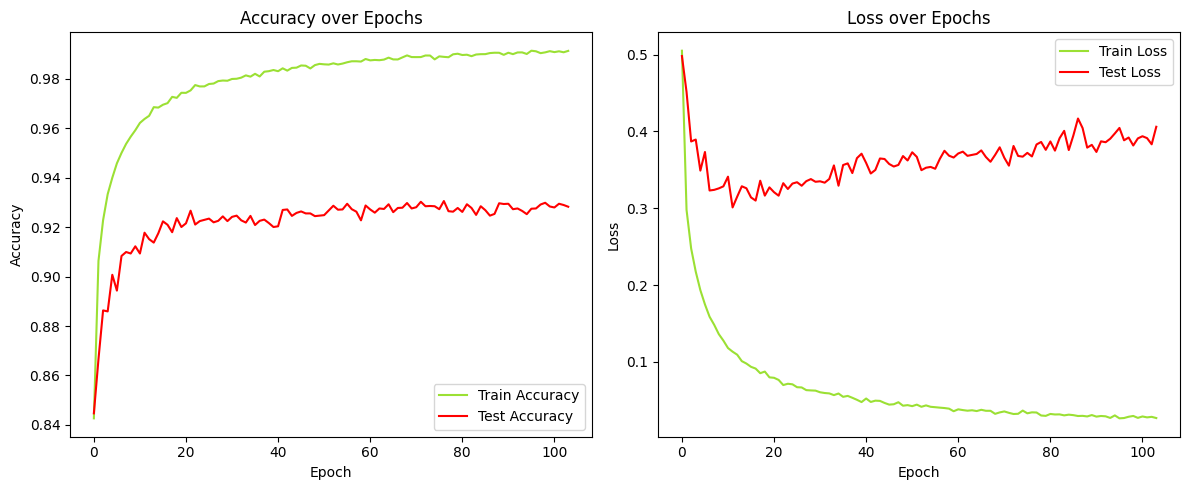

In [19]:
# Get the best accuracy
best_acc = results_MLP_3H['val_accuracy'].max()

print(f'Best grid search accuracy: {best_acc}')

# Get the index for the best run
best_indices = results_MLP_3H.loc[results_MLP_3H['val_accuracy']==best_acc, :].index

if best_indices.shape[0] > 1:
    print(f'Multiple runs with accuracy = {best_acc}. \nBest indices = {best_indices.values}.')
    best_idx = int(input(f'Which index do you want to consider?\nOptions: {best_indices.values}'))
    assert best_idx in best_indices.values, 'Invalid index!'
else:
    best_idx = best_indices[0]

print(f'Best run index: {best_idx}')

# Load the best model
#best_model_path = results_MLP_3H.iloc[best_idx, -1]

#best_MLP_1H = tf.keras.models.load_model(best_model_path)

# Train the best configuration on the training + validation set
## Get the best configuration parameters
best_lr, best_dropout, best_hu1, best_hu2, best_hu3, best_optimizer = results_MLP_3H.iloc[best_idx, :6]

best_MLP_3H = build_tf_model_3H(hidden_units1= best_hu1, hidden_units2= best_hu2, hidden_units3= best_hu3, dropout= best_dropout, optimizer_name= best_optimizer, lr = best_lr)

early_stop = EarlyStopping(
    monitor='loss',
    min_delta = 0.001,    
    patience=10,            # number of epochs with no improvement after which training will be stopped
    restore_best_weights=True,
    mode = 'min',
    verbose = 1  # restores model weights from the epoch with the best value of the monitored quantity
)


start_time = time.time()

history_MLP_3H = best_MLP_3H.fit(np.vstack((train_images_norm, validation_images_norm)), np.vstack((train_labels, validation_labels)), 
                          epochs = 300,
                          callbacks = [early_stop],
                          validation_data = (test_images_norm, pd.get_dummies(test_labels, dtype= int).to_numpy()))

end_time = time.time()

finalTrain_MLP_3H_time = end_time - start_time
print(f"Total final train time for MLP 3H: {(finalTrain_MLP_3H_time)/60:.2f} minutes")

plot_finalTraining_results(history_MLP_3H)

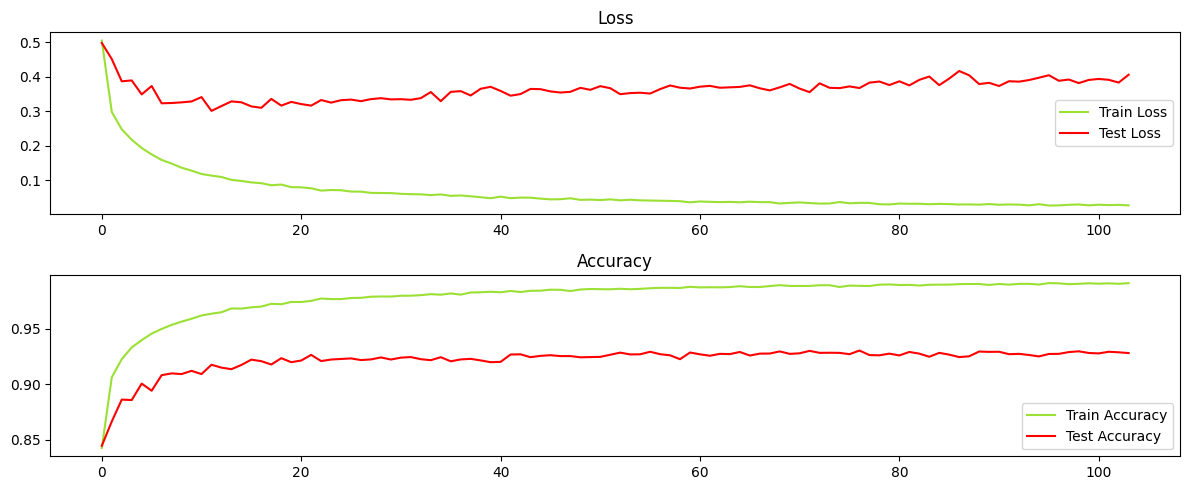

In [31]:
plot_finalTraining_results(history_MLP_3H)

In [22]:
# Save the model after the final training
tf.keras.models.save_model(best_MLP_3H, 'finalModel_MLP_3H.keras')

## 4.3 Obtain model performance
Run a chosen model on the test set (i.e., unseen data) and get the accuracy and confusion matrix

313/313 - 0s - 963us/step - accuracy: 0.9136 - loss: 0.8020 - precision: 0.9156 - recall: 0.9120
Test accuracy: 0.9136
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 742us/step


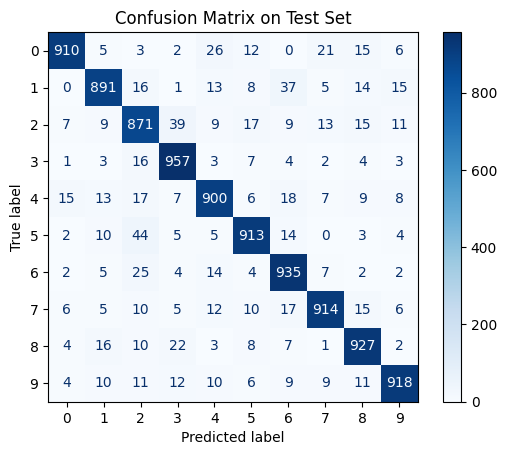

In [20]:
# Evaluate on test set
test_labels = pd.get_dummies(test_labels, dtype= int).to_numpy()
test_loss, test_acc, _, _ = best_MLP_1H.evaluate(test_images_norm, test_labels, verbose=2)
print(f"Test accuracy: {test_acc:.4f}")

test_labels = np.argmax(test_labels, axis=1)

# Predict classes on test set
y_pred_prob = best_MLP_1H.predict(test_images_norm)
y_pred = np.argmax(y_pred_prob, axis=1)

# Create confusion matrix
cm = metrics.confusion_matrix(test_labels, y_pred)

# Plot confusion matrix
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.arange(10))
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix on Test Set")
plt.show()

313/313 - 0s - 1ms/step - accuracy: 0.9265 - loss: 0.3905 - precision: 0.9318 - recall: 0.9244
Test accuracy: 0.9265
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


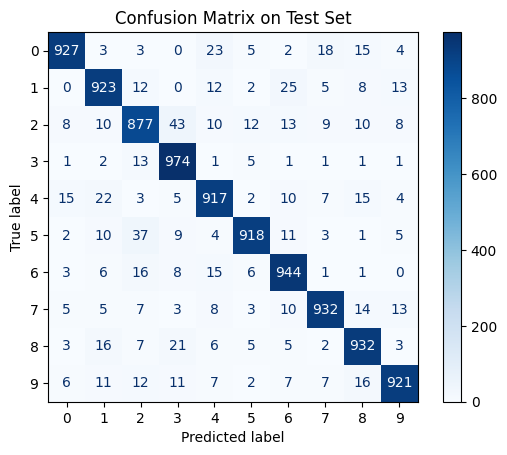

In [21]:
# Evaluate on test set
test_labels = pd.get_dummies(test_labels, dtype= int).to_numpy()
test_loss, test_acc, _, _ = best_MLP_3H.evaluate(test_images_norm, test_labels, verbose=2)
print(f"Test accuracy: {test_acc:.4f}")

test_labels = np.argmax(test_labels, axis=1)

# Predict classes on test set
y_pred_prob = best_MLP_3H.predict(test_images_norm)
y_pred = np.argmax(y_pred_prob, axis=1)

# Create confusion matrix
cm = metrics.confusion_matrix(test_labels, y_pred)

# Plot confusion matrix
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.arange(10))
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix on Test Set")
plt.show()